## Final Project Submission

Please fill out:
* Student name: Lisa Arends
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Claude Fried
* Blog post URL: https://fromteachingtotech928923879.wordpress.com/2021/08/06/the-problem-with-teaching-to-the-test/


# Problem Statement


Premium Remodeling is a company based in King County, WA that specializes in additions and the creation of new rooms. Their target market is the more than 16,000 homeowners whose homes are older than twenty years and have not had a renovation since 2000. Their goal is to convince homeowners to complete an addition and/or add a bedroom or bathroom within their existing square footage.

In conversation, it is learned that the online design tool they have on their website receives quite of bit of traffic, but that potential customers leave once they receive a price estimate for the remodeling project.

## Business Value

According to Premium Remodeling, their average bathroom addition costs \\$11,800 and adding 400 square feet to a home has an average cost of \\$65,000. Because this is such a major investment, homeowners will be more likely to proceed with a remodeling project if they know how it will increase the predicted sale price for their home. This analysis will allow homeowners to see the current predicted sale price for their home as well as the predicted sale price if they add a bathroom, bedroom and/or square footage to their existing home. By seeing the value of the remodeling project, homeowners will be more likely to hire Premium Remodeling to complete the work.

In addition, information from this analysis will provide information for Premium Remodeling on which areas to target advertising based on where homeowners are more likely to have older homes that have not been recently remodeled or home with fewer bedrooms and/or bathrooms than average.

## Questions to Consider

- When and why are potential customers leaving the website?
- How does the addition of a bathroom, bedroom and/or square footage increase the predicted sales price of a particular house, all other factors held constant?


## Methodology

Data from over 20,000 home sales in King County were analyzed to first determine which home features are most correlated with sales price. Based on the visualizations of the data and the correlations, several features were selected to focus on and the data were transformed into the correct formats for regression. 

Before standardizing the numerical data and one-hot-encoding the categorical features, the data were split into training and testing sets in order to avoid data leakage. Nine different models were created and their metrics were evaluated for how well the model described the data, the error rate, signs of overfitting or multicollinearity and any conflicts with the assumptions of linear regression (linear relationships, normally distributed residuals, homoskedasticity and independence of independent variables). 

Finally, the most effective model was selected and a pipeline was created in order to use the model to predict the sales price of newly provided home data. 

# Obtain the Data

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from scipy import stats

import math


In [2]:
#Set visualization parameters.
NEUTRAL = '#0784b1'
HIGHLIGHT = '#9fe2d0'
DULL = '#80828b'
cmap = sns.color_palette("ch:start=.2,rot=-.5", as_cmap=True)
sns.set_style('dark')

In [3]:
#import data
housing = pd.read_csv('data/kc_house_data.csv')
city_by_zip = pd.read_html(
    'https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033'
)
city_by_zip = pd.concat((
    city_by_zip[2], 
    city_by_zip[3], 
    city_by_zip[4]), 
    axis = 0)
city_by_zip = city_by_zip.to_dict(orient="records")


# Initial Exploration

In [4]:
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


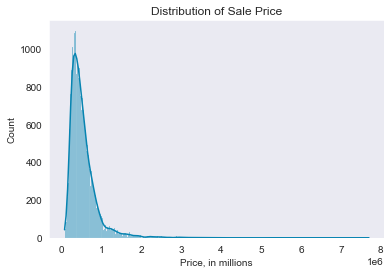

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(
    housing['price'], 
    color=NEUTRAL,
    kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Price, in millions');

# heavily right skewed

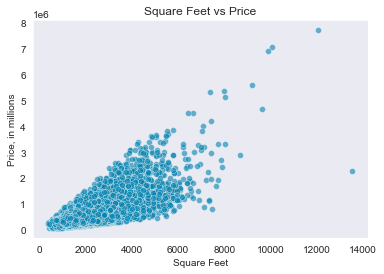

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(
    data=housing, 
    x='sqft_living', 
    y='price', 
    alpha=0.6, 
    color=NEUTRAL)
plt.title('Square Feet vs Price')
plt.ylabel('Price, in millions')
plt.xlabel('Square Feet');

#fan-shaped, but shows a linear correlation; the larger houses have more
#variability in price

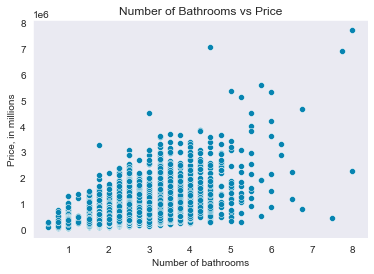

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(
    data=housing, 
    x='bathrooms', 
    y='price', 
    color=NEUTRAL)
plt.title('Number of Bathrooms vs Price')
plt.ylabel('Price, in millions')
plt.xlabel('Number of bathrooms');

#fan-shaped, but shows a linear correlation; the larger number of bathrooms 
#have more variability in price

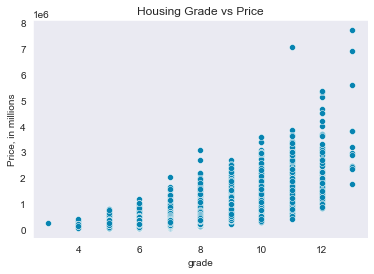

In [10]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(
    data=housing, 
    x='grade', 
    y='price', 
    color=NEUTRAL)
plt.title('Housing Grade vs Price')
plt.ylabel('Price, in millions');

#shows a correlation; the shape may be more exponential than linear

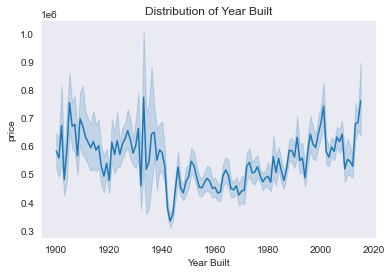

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data = housing, x='yr_built', y='price')
plt.title('Distribution of Year Built')
plt.xlabel('Year Built');

#the more expensive homes are generally built before the 1950s or after the
#1990s; this may be a quadratic relationship

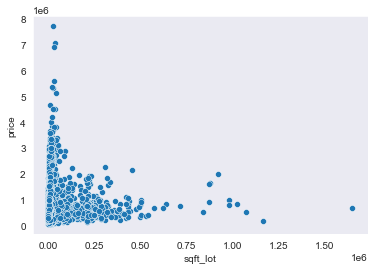

In [12]:
sns.scatterplot(data=housing, x='sqft_lot', y='price');
#there does not seem to be any correlation between the lot size and the price

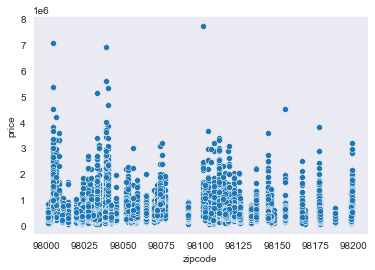

In [13]:
sns.scatterplot(data=housing, x='zipcode', y='price');
#there seems to be a relationship between zipcode and price

# Data Processing

In [14]:
housing_processed = housing.copy()

## Feature Engineering

In [15]:
def get_plot(feature):
    """Takes in a categorical feature and creates a barplot of that feature vs
    sales price."""
    
    data = (
    housing_processed
    .groupby(feature)
    .median()
    .reset_index()
    .sort_values('price')
)
    
    fig, ax = plt.subplots(figsize=(14,12))
    sns.barplot(
        data=data, 
        x=data[feature], 
        y=data['price'], 
        color = NEUTRAL
    )
    ax.set_title(f'Change in Median Price for {feature.title()} ')
    plt.xlabel(feature)
    plt.ylabel('Price in millions')
    ax.set_xticklabels(labels=data[feature], rotation=270)

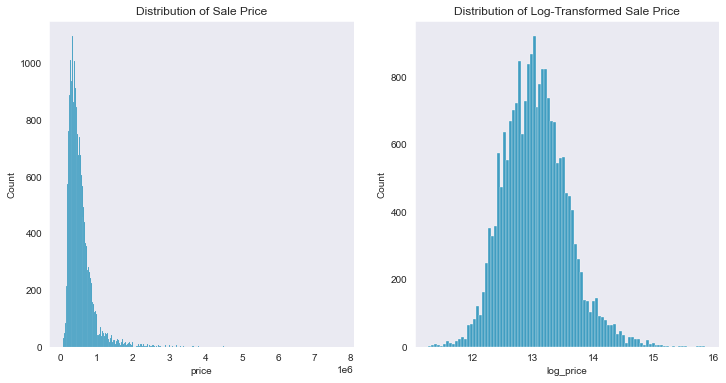

In [16]:
#Log transform the target column because price has a very long right tail.
housing_processed['log_price'] = np.log(housing_processed['price'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.histplot(housing_processed['price'], color=NEUTRAL, ax=ax1)
sns.histplot(housing_processed['log_price'], color=NEUTRAL, ax=ax2)
ax1.set_title('Distribution of Sale Price')
ax2.set_title('Distribution of Log-Transformed Sale Price');


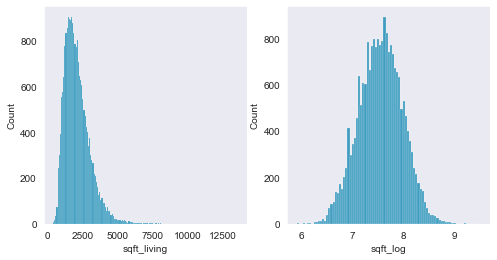

In [17]:
#Log transform the sqft_living columns because it has a long right tail
housing_processed["sqft_log"] = np.log(housing_processed['sqft_living'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
sns.histplot(housing_processed['sqft_living'], color=NEUTRAL, ax=ax1)
sns.histplot(housing_processed['sqft_log'], color=NEUTRAL, ax=ax2);

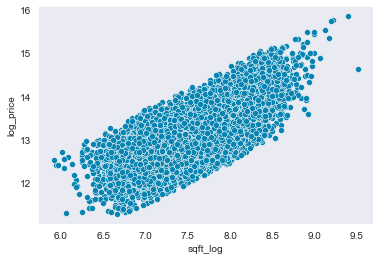

In [18]:
sns.scatterplot(
    data=housing_processed, 
    x='sqft_log', 
    y='log_price', 
    color=NEUTRAL);

#There is a pretty strong linear correlation between sqft_log and log_price.
#This reduces interpretability, so will need to be considered carefully. 

In [19]:
# There is a house with 33 bedrooms and 1.75 bathrooms. 
#This seems like a typo and should be deleted.
housing_processed = housing_processed[housing_processed['bedrooms'] < 15]

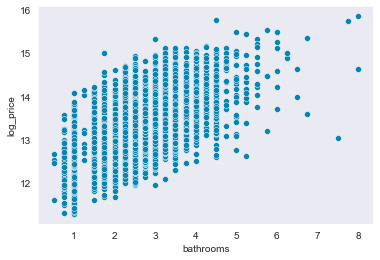

In [20]:
#Add a column that shows the ratio of bathrooms to bedrooms
housing_processed['bath_bed_ratio'] = housing['bathrooms']/housing['bedrooms']

sns.scatterplot(
    data=housing_processed, 
    x='bathrooms', 
    y='log_price', 
    color=NEUTRAL);

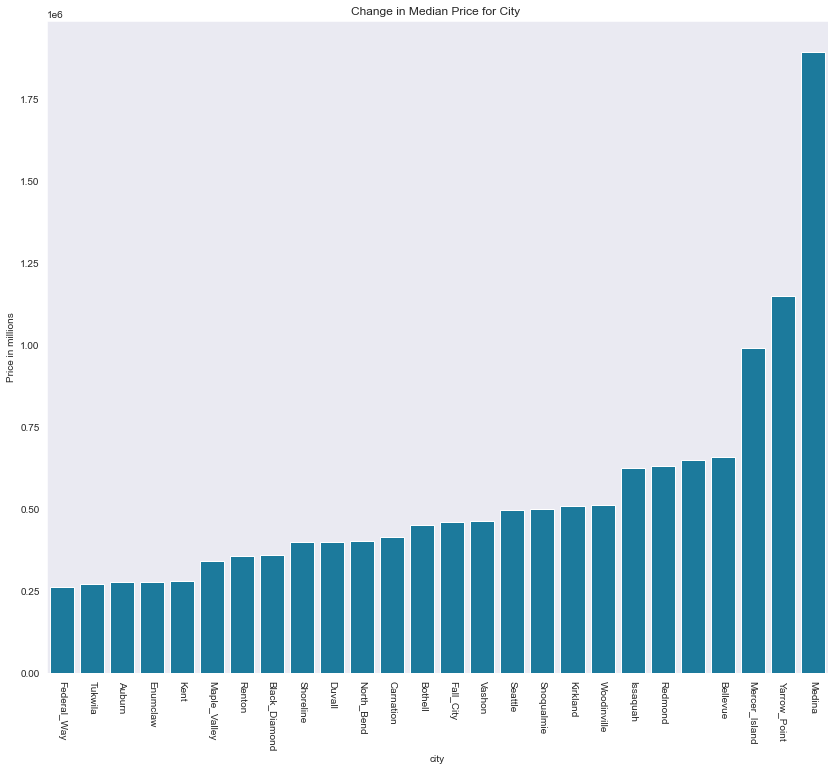

In [21]:
def city(zipcode):
    """ Uses city_by_zip dictionary to create a new city column based on 
    zipcode."""
    city_name = ''
    for city in city_by_zip:
        if city['Zip Code'] == zipcode:
            city_name = city['City']
    return city_name

housing_processed['city'] = (
    housing_processed['zipcode']
    .apply(lambda x: city(x)))
housing_processed['city'] = (
    housing_processed['city']
    .str.replace(' ', '_')) 

get_plot('city')
#The most expensive homes seem to be concentrated in a few cities.

In [22]:
""" Change zipcode to object since it is categorical and not numeric."""
housing_processed['zipcode'] = housing_processed['zipcode'].astype('object')


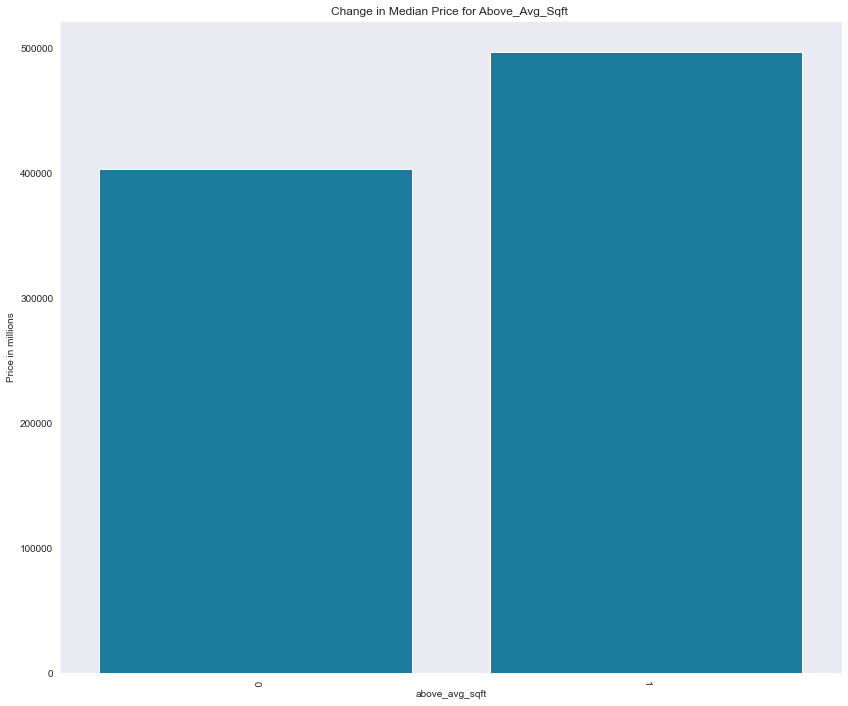

In [23]:
#(Add a new column to indicate if square footage is above average for 
#the area (nearest 15 neighbors). 1 is above or equal to average and 0 is
#below.
housing_processed['above_avg_sqft'] = np.where(
    housing_processed['sqft_living'] >= housing_processed['sqft_living15'],
    1, 0)

get_plot('above_avg_sqft')

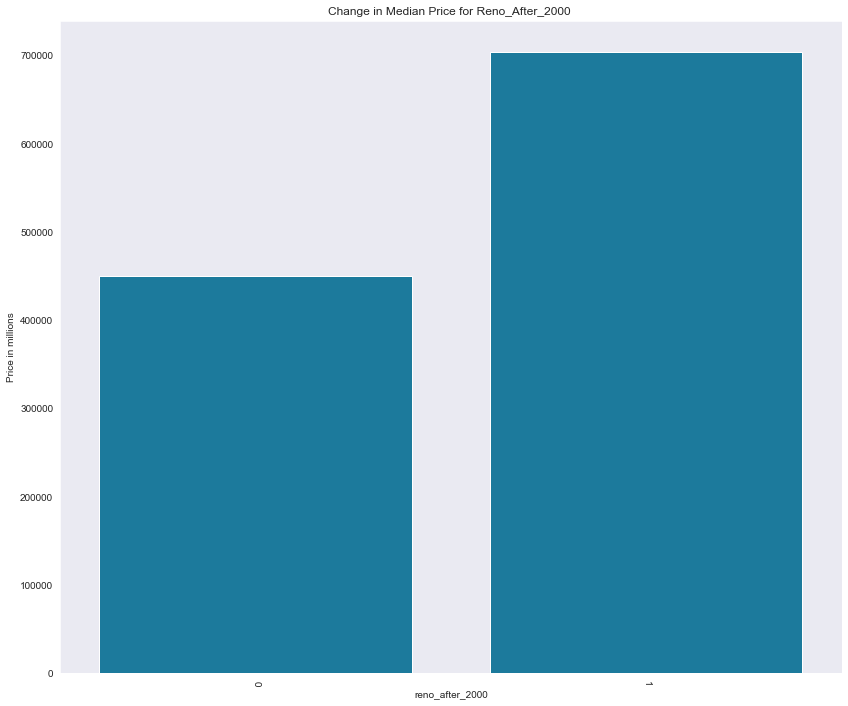

In [24]:
#Add a new column to indicate if the home has been renovated after 2000. 
#1 is yes and 0 is no.
housing_processed['reno_after_2000'] = np.where(
    housing_processed['yr_renovated'] > 2000, 
    1, 0)

get_plot('reno_after_2000')

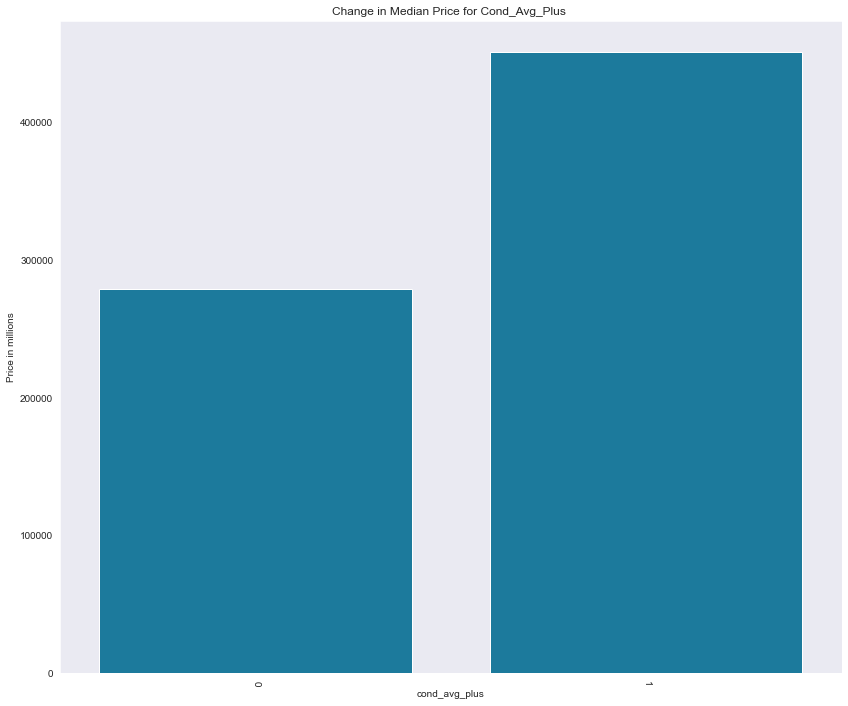

In [25]:
#Add a new column to indicate if the home's condition is 3 or higher
#or below 3. 1 is yes, 0 is no."""
housing_processed['cond_avg_plus'] = np.where(
    housing_processed['condition'] >= 3, 
    1, 0)

get_plot('cond_avg_plus')

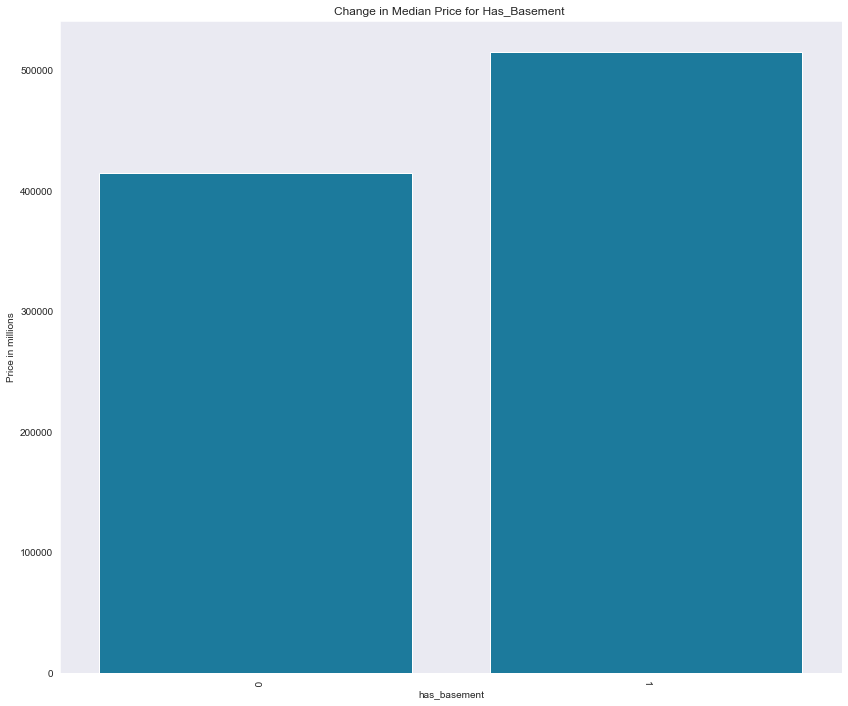

In [26]:
#Add a column to indicate if a house has a basement. 1 indicates yes and
#0 is no.
housing_processed['sqft_basement'] = (
    housing_processed['sqft_basement']
    .str.replace('?','0.0')
    .astype('float'))
housing_processed['has_basement'] = np.where(
    housing_processed['sqft_basement'] > 0, 1, 0)


get_plot('has_basement')

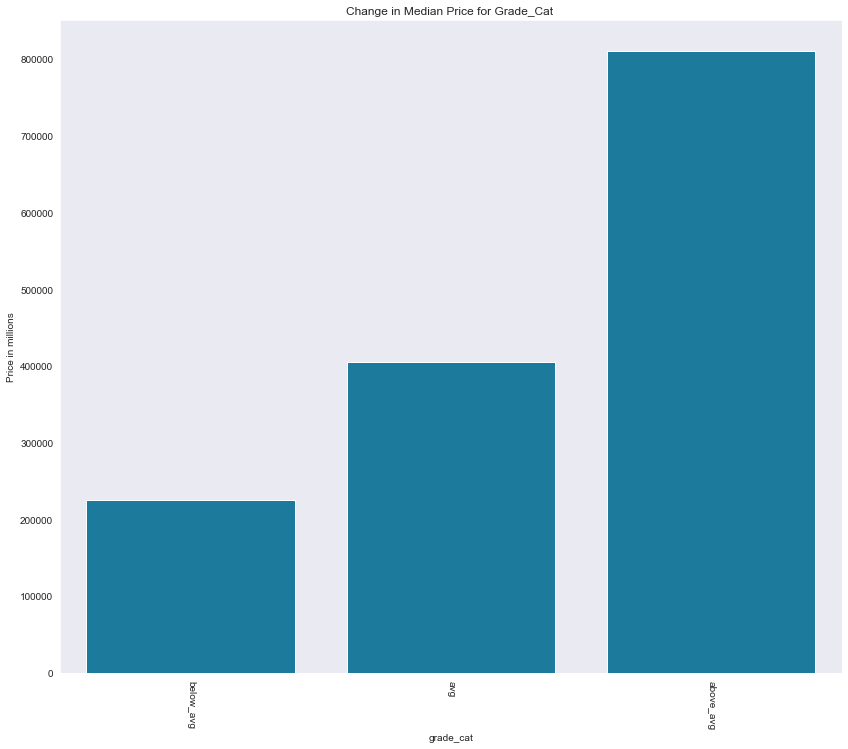

In [27]:
def get_grade(grade):
    """Takes in the numerical value of grade and returns a category:
    below_avg, avg or above_avg"""
    if grade <= 5:
        return 'below_avg'
    elif grade <= 8:
        return 'avg'
    else:
        return 'above_avg'

#Add a categorical columns for grade
housing_processed['grade_cat'] = (housing_processed['grade'].
                                  apply(lambda x: get_grade(x)))

get_plot('grade_cat')

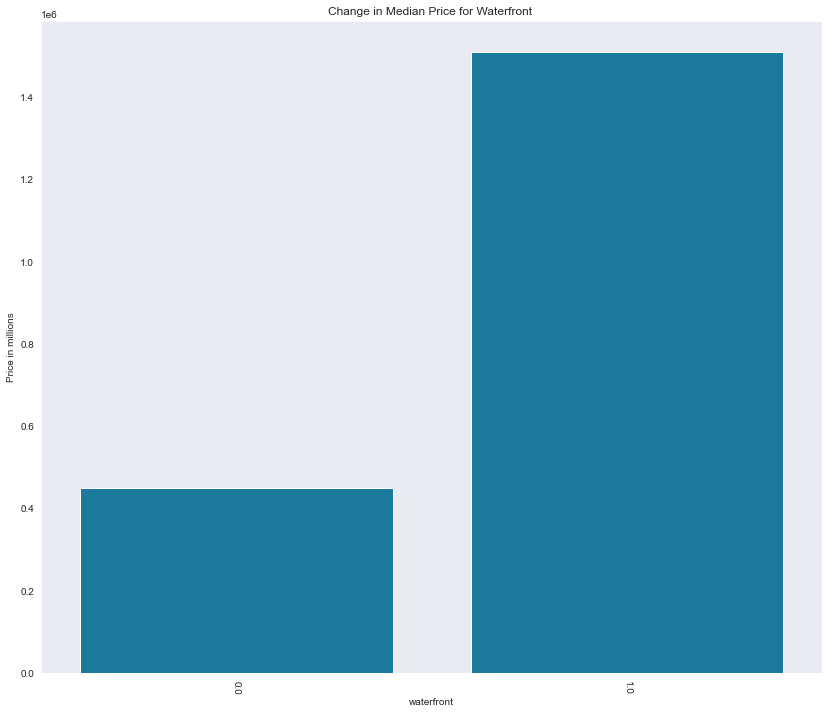

In [28]:
#Replaces null values in waterfront with 0, making the assumption that
#no information about waterfront indicates that the home is not on the water.
housing_processed['waterfront'] = housing_processed['waterfront'].fillna(0)

get_plot('waterfront')

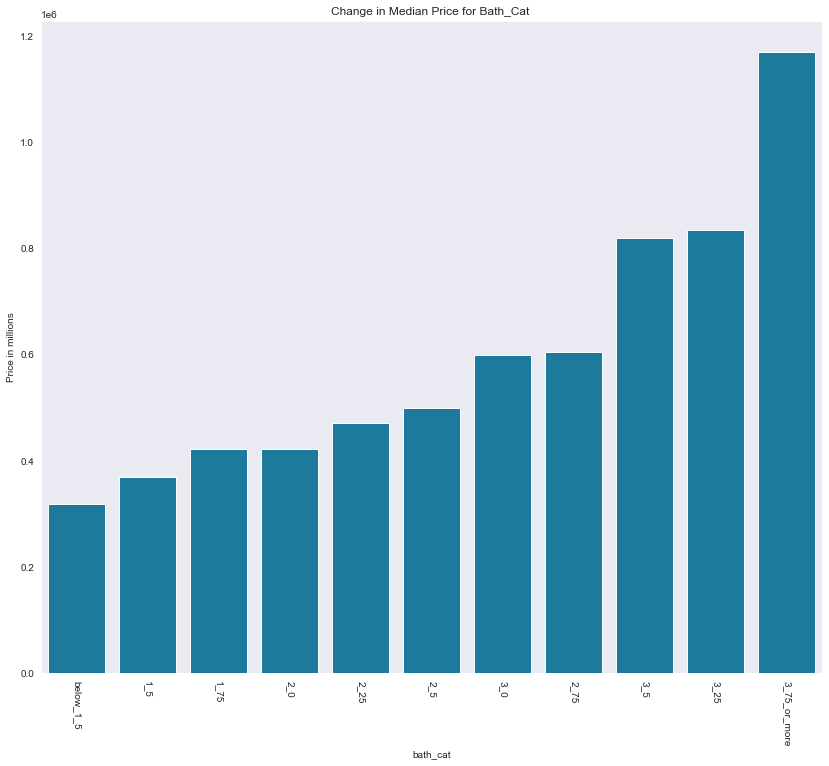

In [29]:
def get_bath_cat(bathrooms):
    """Takes in the numerical value for bathrooms and returns a category."""
    if bathrooms < 1.5:
        return 'below_1_5'
    elif bathrooms >= 3.75:
        return "3_75_or_more"
    else:
        bathrooms =  str(bathrooms).replace('.','_')
        return bathrooms

#Add a column with a categorical value for number of bathrooms.
housing_processed['bath_cat'] = (housing_processed['bathrooms']
                                 .apply(lambda x: get_bath_cat(x)))


get_plot('bath_cat')

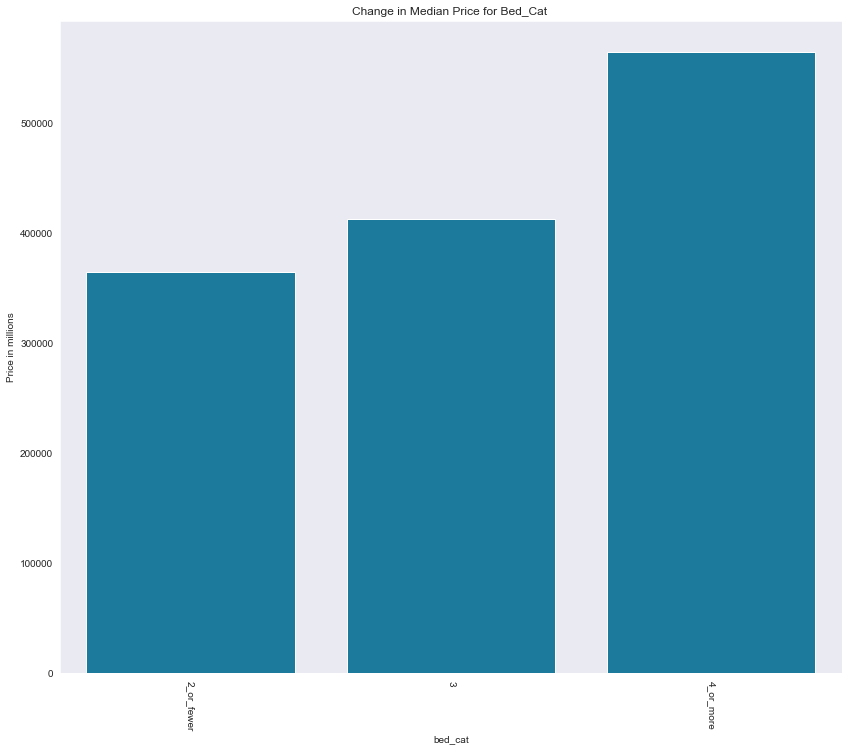

In [30]:
def get_bed_cat(bedrooms):
    """Takes in the numerical value for bedrooms and returns a category."""
    if bedrooms >= 4:
        return '4_or_more'
    elif bedrooms <= 2:
        return '2_or_fewer'
    else:
        return str(bedrooms)

#Add a column with a categorical value for number of bathrooms.
housing_processed['bed_cat'] = (housing_processed['bedrooms']
                                .apply(lambda x: get_bed_cat(x)))


get_plot('bed_cat')

In [31]:
#Add a grade squared column.
housing_processed['grade_2'] = housing_processed['grade']**2

## Feature Selection

In [32]:
#Check for features that have a high correlation with the target.
corr_matrix = housing_processed.corr()
corr_matrix['log_price'].sort_values(ascending=False)

log_price          1.000000
price              0.891746
grade              0.703747
grade_2            0.703534
sqft_living        0.695209
sqft_log           0.674820
sqft_living15      0.619371
sqft_above         0.601621
bathrooms          0.551270
lat                0.448824
bedrooms           0.350871
view               0.345478
sqft_basement      0.313106
floors             0.310665
bath_bed_ratio     0.303498
above_avg_sqft     0.214164
has_basement       0.209071
waterfront         0.170724
yr_renovated       0.118183
sqft_lot           0.100032
cond_avg_plus      0.093917
reno_after_2000    0.093806
sqft_lot15         0.092290
yr_built           0.080608
long               0.050887
condition          0.038855
id                -0.003730
Name: log_price, dtype: float64

Lot square footage was not strongly correlated with price, so those were
removed. Renovation year was dropped because the recent renovations were
picked up in the reno_after_2000 column. Basement square footage was dropped
because the relevant information is in the has_basement column.
View and date sold were also dropped because they are not relevant for the 
target market.

In [33]:
columns_to_keep = ['log_price', 'price', 'bathrooms', 'bedrooms', 
                   'sqft_living','floors', 'waterfront', 'grade', 'sqft_log', 
                   'sqft_living15','yr_built', 'zipcode','lat', 'long', 
                   'above_avg_sqft', 'bath_bed_ratio','reno_after_2000', 
                   'has_basement', 'city', 'bed_cat', 'bath_cat', 'grade_2',
                   'grade_cat']

housing_processed = housing_processed[columns_to_keep]

## Data Summarization and Visualization

In [34]:
#Find houses that were built before 2000 and have not had a renovation since
#2000

older_no_reno = housing_processed[(
    housing_processed['yr_built'] < 2000) 
    & (housing_processed['reno_after_2000'] == 0)]

#There 16,491 homes that may benefit from renovation. They have a median of
#2 bathrooms, 3 bedrooms and 1,820 square feet.
older_no_reno.describe()

,log_price,price,bathrooms,bedrooms,sqft_living,floors,waterfront,grade,sqft_log,sqft_living15,yr_built,lat,long,above_avg_sqft,bath_bed_ratio,reno_after_2000,has_basement,grade_2
count,16491.000000,1.649100e+04,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.000000,16491.0,16491.000000,16491.000000
mean,12.997725,5.114692e+05,1.946228,3.330786,1960.375963,1.332181,0.007459,7.456006,7.496651,1915.904978,1961.261658,47.560526,-122.225580,0.538597,0.596436,0.0,0.415075,56.848645
std,0.523004,3.341622e+05,0.720903,0.907303,837.452874,0.456462,0.086043,1.121022,0.411902,631.892939,25.126257,0.141101,0.133402,0.498523,0.197051,0.0,0.492750,18.017871
min,11.264464,7.800000e+04,0.500000,1.000000,370.000000,1.000000,0.000000,3.000000,5.913503,399.000000,1900.000000,47.155900,-122.519000,0.000000,0.125000,0.0,0.000000,9.000000
25%,12.622477,3.033000e+05,1.500000,3.000000,1370.000000,1.000000,0.000000,7.000000,7.222566,1470.000000,1947.000000,47.464400,-122.331000,0.000000,0.500000,0.0,0.000000,49.000000
50%,12.983101,4.350000e+05,2.000000,3.000000,1820.000000,1.000000,0.000000,7.000000,7.506592,1790.000000,1964.000000,47.573600,-122.254000,1.000000,0.583333,0.0,0.000000,49.000000
75%,13.329378,6.150000e+05,2.500000,4.000000,2380.000000,2.000000,0.000000,8.000000,7.774856,2240.000000,1981.000000,47.680300,-122.146000,1.000000,0.700000,0.0,1.000000,64.000000
max,15.856731,7.700000e+06,8.000000,11.000000,13540.000000,3.500000,1.000000,13.000000,9.513404,5600.000000,1999.000000,47.777600,-121.315000,1.000000,2.500000,0.0,1.000000,169.000000


In [35]:
housing_processed['sqft_living'].describe()

count    21596.000000
mean      2080.343165
std        918.122038
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

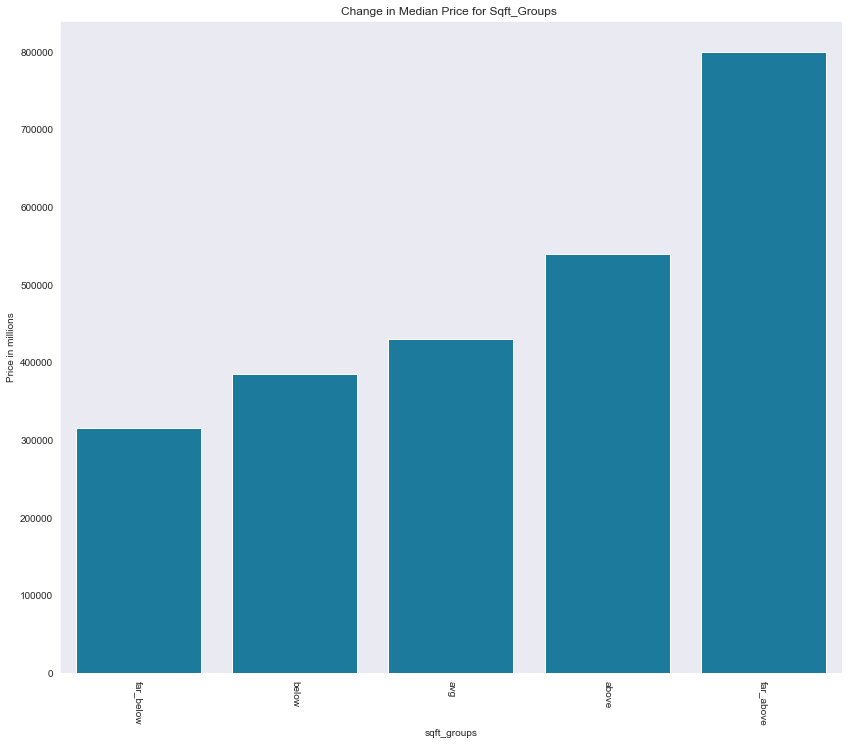

In [36]:
#Look at change in median price for difference size homes
housing_processed['sqft_groups'] = pd.qcut(
    housing_processed['sqft_living'], 
    5, 
    labels = ['far_below', 'below', 'avg', 'above', 'far_above']
)

get_plot('sqft_groups')

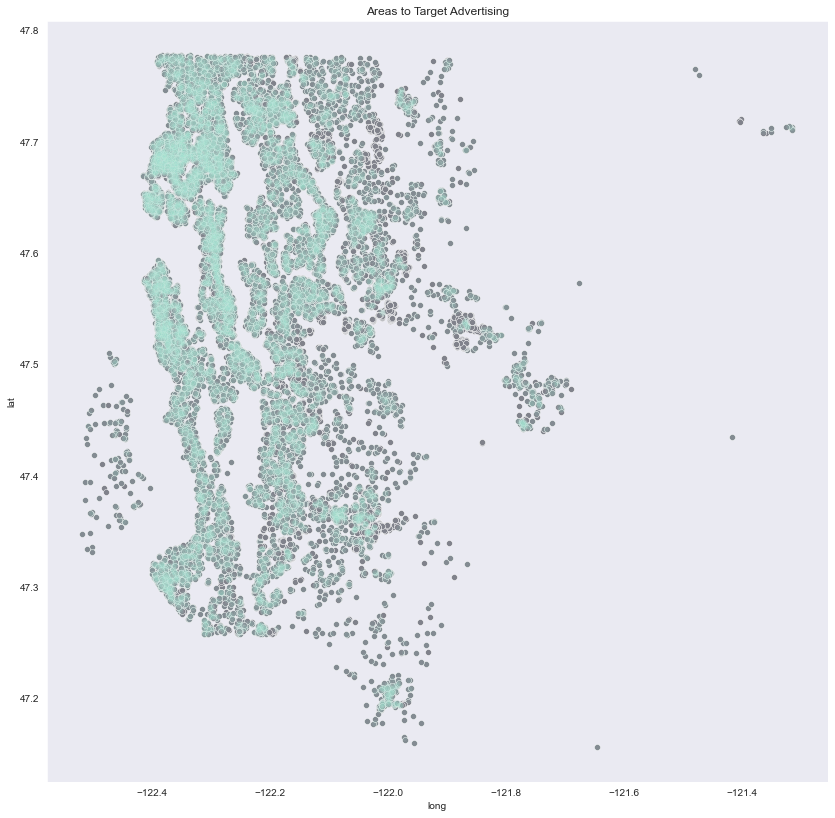

In [37]:
fig, ax = plt.subplots(figsize=(14,14))
sns.scatterplot(data=housing_processed, 
                x='long', 
                y='lat', 
                color=DULL)
sns.scatterplot(data=older_no_reno, 
                x='long', 
                y='lat', 
                color=HIGHLIGHT, 
                alpha=0.1)
plt.title('Areas to Target Advertising');

#target market 

## Feature Transformation

In [38]:
def split_and_process(df, target, test_size=0.25, random_state = 100):
    
    """Takes in a dataframe and the name of the target. Splits the dataframe
    into X_train, X_test, y_train, y_test. Next, the features are divided into
    numerical and categorical and are scaled and one-hot-encoded, 
    respectively. Finally, these are changed back into dataframes and the 
    transformed X_train, X_test, y_train, y_test dataframes are returned."""
    
    df = df.copy()
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,y, test_size=test_size, random_state=random_state)
    
    num = X_train.select_dtypes('number').columns
    cat = X_train.select_dtypes('object').columns
    
   
    ohe = OneHotEncoder(drop='first', sparse=False)
    X_train_cat = ohe.fit_transform(X_train[cat])
    X_train_cat = pd.DataFrame(X_train_cat, 
                               columns = ohe.get_feature_names(cat))

    X_test_cat = ohe.transform(X_test[cat])
    X_test_cat = pd.DataFrame(X_test_cat, 
                              columns = ohe.get_feature_names(cat))
    
    
    
    scale = StandardScaler()
    X_train_num = scale.fit_transform(X_train[num])
    X_train_num = pd.DataFrame(X_train_num, columns=num)

    X_test_num = scale.transform(X_test[num])
    X_test_num = pd.DataFrame(X_test_num, columns = num)
    
    X_train_processed = pd.concat([X_train_num, X_train_cat], 
                                  axis=1).reset_index(drop=True)
    X_test_processed = pd.concat([X_test_num, X_test_cat], axis=1)

    y_train = y_train.reset_index(drop=True)
    
    return X_train_processed, X_test_processed, y_train, y_test


# Modeling

In [39]:
model_scores = {}

def validation(name, model, X_train, y_train, residuals):
    
    """Takes in the informal name of the model, the variable assigned to the 
     model, the X_train and y_train dataframes and a list of the residuals.
     The following metrics are calculated: Jarque-Bera, Durbin-Watson, 
     variance inflation factors (the count of the features with a VIF over 10 
     is returned), R^2, adjusted R^2, mean absolute error, mean squared error, 
     and the root mean squared error. These are appended to a dictionary,
     which is then is returned."""

    JB = stats.jarque_bera(residuals)
    DW = durbin_watson(residuals)
    
    vif_dict = {}
    for i in range(len(X_train.columns)):
        vif = variance_inflation_factor(X_train.values, i)
        v = X_train.columns[i]
        vif_dict[v] = vif

    vif_count = len([v for v in vif_dict.values() if v >= 10])
  
    scores = cross_validate(model, X_train, y_train, cv=5,
                           scoring = ('r2', 
                                      'neg_mean_absolute_error',
                                      'neg_mean_squared_error'),
                           return_train_score=True)

    metrics_dict = {}

    metrics_dict['train_R2'] = scores['train_r2'].mean()
    metrics_dict['test_R2'] = scores['test_r2'].mean()
    metrics_dict['train_mae'] = scores['train_neg_mean_absolute_error'].mean()
    metrics_dict['test_mae'] = scores['test_neg_mean_absolute_error'].mean()
    metrics_dict['train_mse'] = scores['train_neg_mean_squared_error'].mean()
    metrics_dict['test_mse'] = scores['test_neg_mean_squared_error'].mean()
    metrics_dict['train_rsme'] = (-1 * metrics_dict['train_mse'])**.5
    metrics_dict['test_rsme'] = (-1 * metrics_dict['test_mse'])**.5
    metrics_dict['JB'] = JB
    metrics_dict['VIF_over_10'] = vif_count
    metrics_dict['Durbin-Watson'] = DW

    model_scores[name] = metrics_dict
    return model_scores

In [40]:
def get_high_vif(X_train, threshold=10):
    
    """Takes in X_train and a threshold and returns a dictionary with the 
    name of each feature with a VIF over the threshold and its respective VIF 
    score."""
    
    vif_dict = {}
    for i in range(len(X_train.columns)):
        vif = variance_inflation_factor(X_train.values, i)
        if vif >= threshold:
            v = X_train.columns[i]
            vif_dict[v] = vif
    return vif_dict
    
  

In [41]:
def make_scatter(y_pred, residuals_train, residuals_test):
    
    """Takes in the predicted y values and lists of the train and test 
    residuals. Returns two scatterplots, one of the train residuals and
    one of the test."""
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
    fig.tight_layout()
    ax1.scatter(x=y_pred, y=residuals_train, color=NEUTRAL)
    ax1.axhline(0, color=HIGHLIGHT)
    ax1.set_title('Training Residuals')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Residuals')
    ax2.scatter(x=y_pred, y=residuals_test, color=NEUTRAL)
    ax2.axhline(0, color=HIGHLIGHT)
    ax2.set_title('Test Residuals')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Residuals')
    
def make_hist(residuals_train, residuals_test):
    
    """Takes in lists of the train and test residuals. Returns four graphs:
    a histogram and a boxplot for each."""
    
    data = np.random.normal(0, 1, 10000)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))

    ax1.hist(
        data, 
        color=HIGHLIGHT, 
        alpha=0.5, 
        label='normal distribution', 
        bins=100, 
        density=True, 
        histtype='step', 
        linewidth=4
    )
    ax1.hist(
        residuals_train, 
        color = NEUTRAL, 
        label = 'training residuals', 
        bins=50, 
        density=True
    )
    ax1.set_title('Training Residuals')
    ax1.legend()
    ax2.boxplot(residuals_train)
    ax2.set_title('Training Residuals')
    ax3.hist(
        data, 
        color=HIGHLIGHT, 
        alpha=0.5, 
        label='normal distribution', 
        bins=100, 
        density=True, 
        histtype='step', 
        linewidth=4
    )
    ax3.hist(
        residuals_test, 
        color = NEUTRAL, 
        label = 'training residuals', 
        bins=50, 
        density=True)
    ax3.set_title('Test Residuals')
    ax3.legend()
    ax4.boxplot(residuals_test)
    ax4.set_title('Test Residuals')
    for ax in fig.get_axes():
        ax.label_outer()

    
    
    
def make_qq(residuals):
    
    """Takes in a list of residuals and returns a qq-plot."""
    
    sm.graphics.qqplot(residuals, line='s')

## Initial Model

In [42]:
#Features are selected that show stong correlation with the target and
#do not have significant multicollinearity with each other. 

cols = ['log_price', 'sqft_living','floors', 'waterfront', 'grade_cat',  
        'yr_built', 'zipcode', 'reno_after_2000', 'bath_cat', 'bed_cat']

housing_processed_select = housing_processed[cols]


In [43]:
X_train_processed, X_test_processed, y_train, y_test = split_and_process(
                                    housing_processed_select, 'log_price')

train_df_processed = pd.concat([X_train_processed, y_train], axis = 1)

X_train_processed.shape, X_test_processed.shape, train_df_processed.shape


((16197, 88), (5399, 88), (16197, 89))

In [44]:
formula = f"{y_train.name} ~ {'+'.join(X_train_processed.columns)}"
model = ols(formula=formula, data=train_df_processed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1048.
Date:                Thu, 19 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:35:59   Log-Likelihood:                 2862.9
No. Observations:               16197   AIC:                            -5548.
Df Residuals:                   16108   BIC:                            -4863.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.6640      0.016    811.973      0.000      12.633      12.695
sqft_living               0.2442      0.003     79.522      0.000       0.238       0.250
floors                   -0.0052      0.002     -2.306      0.021      -0.010      -0.001
waterfront                0.0555      0.002     33.683      0.000       0.052       0.059
yr_built                 -0.0307      0.003    -12.239      0.000      -0.036      -0.026
reno_after_2000           0.0076      0.002      4.675      0.000       0.004       0.011
grade_cat_avg            -0.1912      0.006    -34.312      0.000      -0.202      -0.180
grade_cat_below_avg      -0.3637      0.016    -22.124      0.000      -0.396      -0.331
zipcode_98002            -0.0527      0.021     -2.560      0.010      -0.093      -0.012
zipcode_98003             0.0393      0.019      2.046      0.041       0.002       0.077
zipcode_98004             1.1370      0.018     62.458      0.000       1.101       1.173
zipcode_98005             0.7640      0.022     34.893      0.000       0.721       0.807
zipcode_98006             0.6863      0.016     41.686      0.000       0.654       0.719
zipcode_98007             0.6739      0.024     28.631      0.000       0.628       0.720
zipcode_98008             0.6820      0.019     35.553      0.000       0.644       0.720
zipcode_98010             0.2905      0.026     11.225      0.000       0.240       0.341
zipcode_98011             0.4435      0.022     20.601      0.000       0.401       0.486
zipcode_98014             0.3289      0.025     13.146      0.000       0.280       0.378
zipcode_98019             0.3313      0.021     15.750      0.000       0.290       0.373
zipcode_98022             0.1374      0.020      6.984      0.000       0.099       0.176
zipcode_98023            -0.0265      0.016     -1.618      0.106      -0.059       0.006
zipcode_98024             0.4510      0.031     14.461      0.000       0.390       0.512
zipcode_98027             0.5457      0.017     31.869      0.000       0.512       0.579
zipcode_98028             0.4186      0.019     22.504      0.000       0.382       0.455
zipcode_98029             0.6119      0.018     33.522      0.000       0.576       0.648
zipcode_98030             0.0461      0.020      2.365      0.018       0.008       0.084
zipcode_98031             0.0802      0.019      4.172      0.000       0.043       0.118
zipcode_98032            -0.0185      0.025     -0.749      0.454      -0.067       0.030
zipcode_98033             0.7879      0.017     46.709      0.000       0.755       0.821
zipcode_98034             0.5435      0.016     33.682      0.000       0.512       0.575
zipcode_98038             0.1839      0.016     11.408      0.000       0.152       0.216
zipcode_98039          

In [45]:
lr = LinearRegression().fit(X_train_processed, y_train)
y_pred = lr.predict(X_test_processed)

def get_residuals(y_test, y_pred):
    return [list(y_test)[i] - list(y_pred)[i] for i in range(len(y_test))]



residuals_test = get_residuals(y_test, y_pred)
residuals_train = get_residuals(y_test, y_train)

### Validation of the Initial Model

In [46]:
model_scores = validation('initial', 
                          lr, 
                          X_train_processed, 
                          y_train, 
                          residuals_test)
model_scores

{'initial': {'train_R2': 0.8514478453545428,
  'test_R2': 0.8495357089981125,
  'train_mae': -0.14831976789577372,
  'test_mae': -0.14921840883645582,
  'train_mse': -0.041063799871280525,
  'test_mse': -0.04157491942709501,
  'train_rsme': 0.20264204862584795,
  'test_rsme': 0.20389928746097916,
  'JB': Jarque_beraResult(statistic=1304.183728714113, pvalue=0.0),
  'VIF_over_10': 0,
  'Durbin-Watson': 1.9764790030122266}}

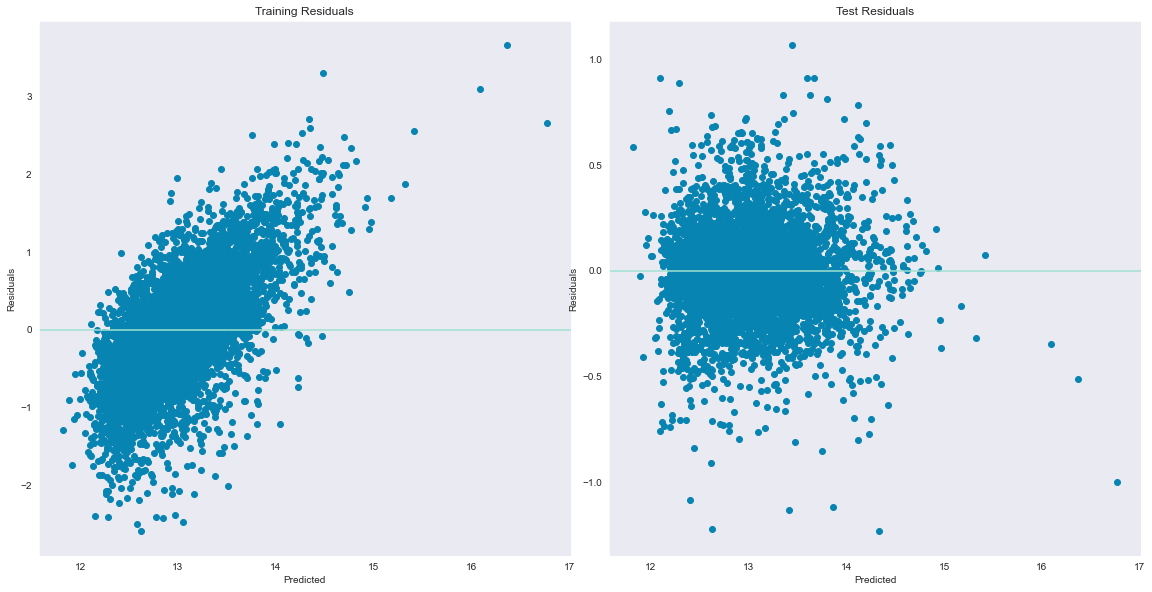

In [47]:
make_scatter(y_pred, residuals_train, residuals_test)

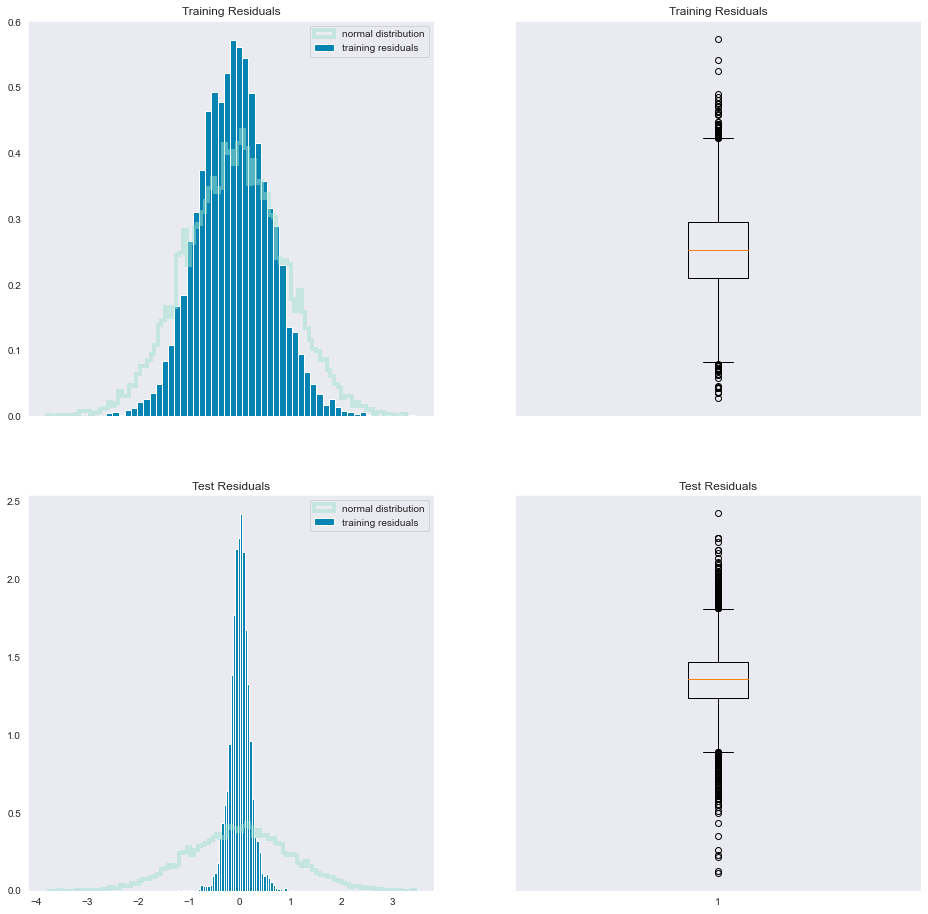

In [48]:
make_hist(residuals_train, residuals_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


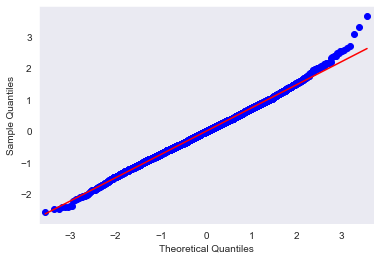

In [49]:
make_qq(pd.Series(residuals_train))

<AxesSubplot:>

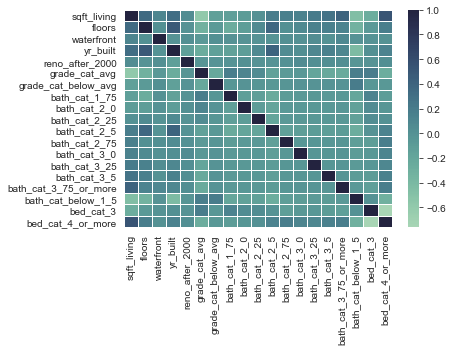

In [50]:
def get_cols(X_train):
    cols_hm = ([c for c in X_train.columns if 'zipcode' not in c])
    return cols_hm

cols_hm = get_cols(X_train_processed)

sns.heatmap(X_train_processed[cols_hm].corr(), 
            center=0, 
            linewidths=.5, 
            cmap=cmap)


### Analysis of Initial Model


There are significant outliers in the data, which is especially clear in the scatter plots. 

The VIF scores indicate that the predictors are independent, the Durbin-Watson score indicates that the residuals are homoscedastic but the J-B score and qq-plot show that the residuals are not normally distributed. The distribution plots make it clear that the residuals are strongly clustered around 0.

The R^2 is high at 0.851 and the adjusted R^2 is close at 0.850. That, and the closeness of the RMSEs suggests that there is no overfitting. 

## Model With Outliers Removed

In [51]:
#We can remove around 1100 rows and still maintain 95% of the data.
upper = housing_processed_select['log_price'].quantile(.975)
lower = housing_processed_select['log_price'].quantile(.025)
housing_no_outlier = housing_processed_select[(
    housing_processed_select['log_price'] < 
    upper)&(housing_processed_select['log_price'] 
            > lower
           )]

housing_processed.shape, housing_no_outlier.shape

((21596, 24), (20489, 10))

In [52]:
housing_no_outlier_processed = housing_no_outlier.copy()

In [53]:
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = split_and_process(
    housing_no_outlier_processed, 'log_price')

train_df_no_out = pd.concat([X_train_no_out, y_train_no_out], axis = 1)
X_train_no_out.shape, y_train_no_out.shape, train_df_no_out.shape


((15366, 88), (15366,), (15366, 89))

In [54]:
formula_no_out = f"{y_train_no_out.name} ~ {'+'.join(X_train_no_out.columns)}"
model_no_out = ols(formula=formula_no_out, data=train_df_no_out).fit()
model_no_out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     833.7
Date:                Thu, 19 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:36:22   Log-Likelihood:                 4124.1
No. Observations:               15366   AIC:                            -8070.
Df Residuals:                   15277   BIC:                            -7390.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.6870      0.015    841.277      0.000      12.657      12.717
sqft_living               0.2095      0.003     74.930      0.000       0.204       0.215
floors                   -0.0015      0.002     -0.704      0.482      -0.006       0.003
waterfront                0.0373      0.002     23.980      0.000       0.034       0.040
yr_built                 -0.0311      0.002    -13.065      0.000      -0.036      -0.026
reno_after_2000           0.0066      0.002      4.321      0.000       0.004       0.010
grade_cat_avg            -0.1783      0.005    -34.200      0.000      -0.188      -0.168
grade_cat_below_avg      -0.2643      0.017    -15.303      0.000      -0.298      -0.230
zipcode_98002            -0.0492      0.021     -2.334      0.020      -0.091      -0.008
zipcode_98003             0.0190      0.018      1.039      0.299      -0.017       0.055
zipcode_98004             1.0955      0.019     57.420      0.000       1.058       1.133
zipcode_98005             0.7505      0.020     36.755      0.000       0.710       0.790
zipcode_98006             0.6691      0.016     42.170      0.000       0.638       0.700
zipcode_98007             0.6564      0.022     29.825      0.000       0.613       0.700
zipcode_98008             0.6493      0.018     36.570      0.000       0.614       0.684
zipcode_98010             0.2823      0.025     11.296      0.000       0.233       0.331
zipcode_98011             0.4347      0.020     22.250      0.000       0.396       0.473
zipcode_98014             0.3760      0.023     16.051      0.000       0.330       0.422
zipcode_98019             0.3265      0.020     16.606      0.000       0.288       0.365
zipcode_98022             0.1169      0.019      6.044      0.000       0.079       0.155
zipcode_98023            -0.0201      0.016     -1.269      0.204      -0.051       0.011
zipcode_98024             0.3698      0.029     12.947      0.000       0.314       0.426
zipcode_98027             0.5206      0.017     31.456      0.000       0.488       0.553
zipcode_98028             0.4068      0.018     22.687      0.000       0.372       0.442
zipcode_98029             0.5955      0.017     34.255      0.000       0.561       0.630
zipcode_98030             0.0460      0.019      2.469      0.014       0.009       0.082
zipcode_98031             0.0578      0.018      3.225      0.001       0.023       0.093
zipcode_98032            -0.0044      0.023     -0.191      0.849      -0.050       0.041
zipcode_98033             0.7572      0.016     46.283      0.000       0.725       0.789
zipcode_98034             0.5041      0.015     32.823      0.000       0.474       0.534
zipcode_98038             0.1660      0.015     10.857      0.000       0.136       0.196
zipcode_98039          

In [55]:
lr_no_out = LinearRegression().fit(X_train_no_out, y_train_no_out)
y_pred_no_out = lr_no_out.predict(X_test_no_out)

residuals_no_out_test = get_residuals(y_test_no_out, y_pred_no_out)
residuals_no_out_train = get_residuals(y_test_no_out, y_train_no_out)

### Validation of the Model With Outliers Removed

In [56]:
model_scores = validation('no_outliers', 
                          lr_no_out, 
                          X_train_no_out, 
                          y_train_no_out, 
                          residuals_no_out_test)
model_scores['no_outliers']

{'train_R2': 0.8279104673251154,
 'test_R2': 0.8253042849381738,
 'train_mae': -0.1380699884461119,
 'test_mae': -0.13899315354183744,
 'train_mse': -0.03417972820541672,
 'test_mse': -0.03468176742719976,
 'train_rsme': 0.18487760330936984,
 'test_rsme': 0.18623041488220918,
 'JB': Jarque_beraResult(statistic=1060.1194380265356, pvalue=0.0),
 'VIF_over_10': 0,
 'Durbin-Watson': 1.963120985869246}

In [57]:
get_high_vif(X_train_no_out)

{}

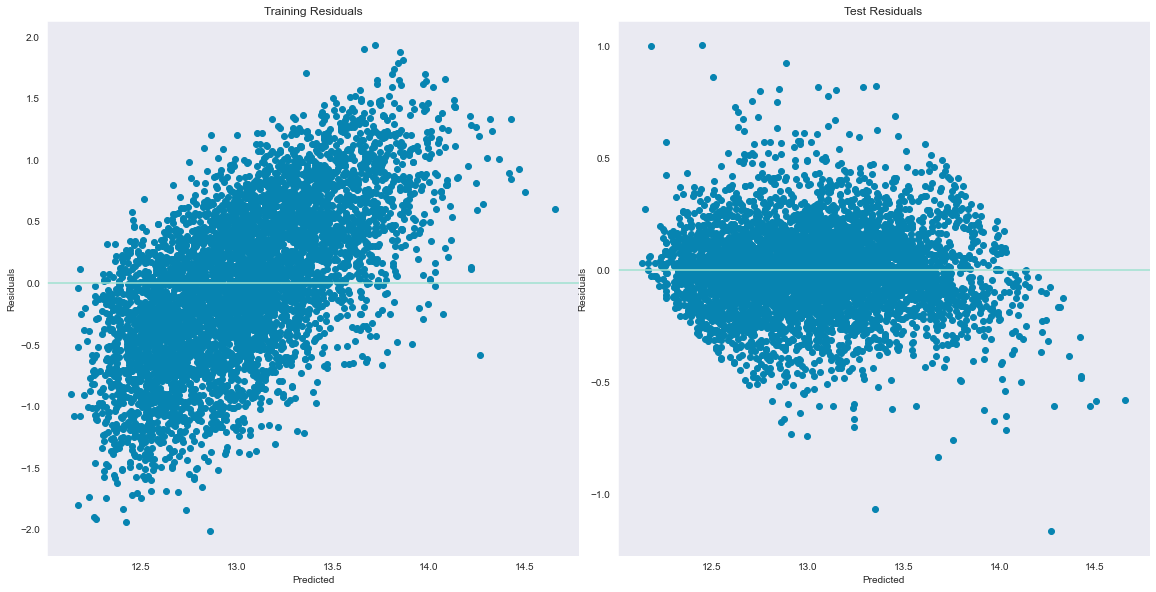

In [58]:
make_scatter(y_pred_no_out, residuals_no_out_train, residuals_no_out_test)

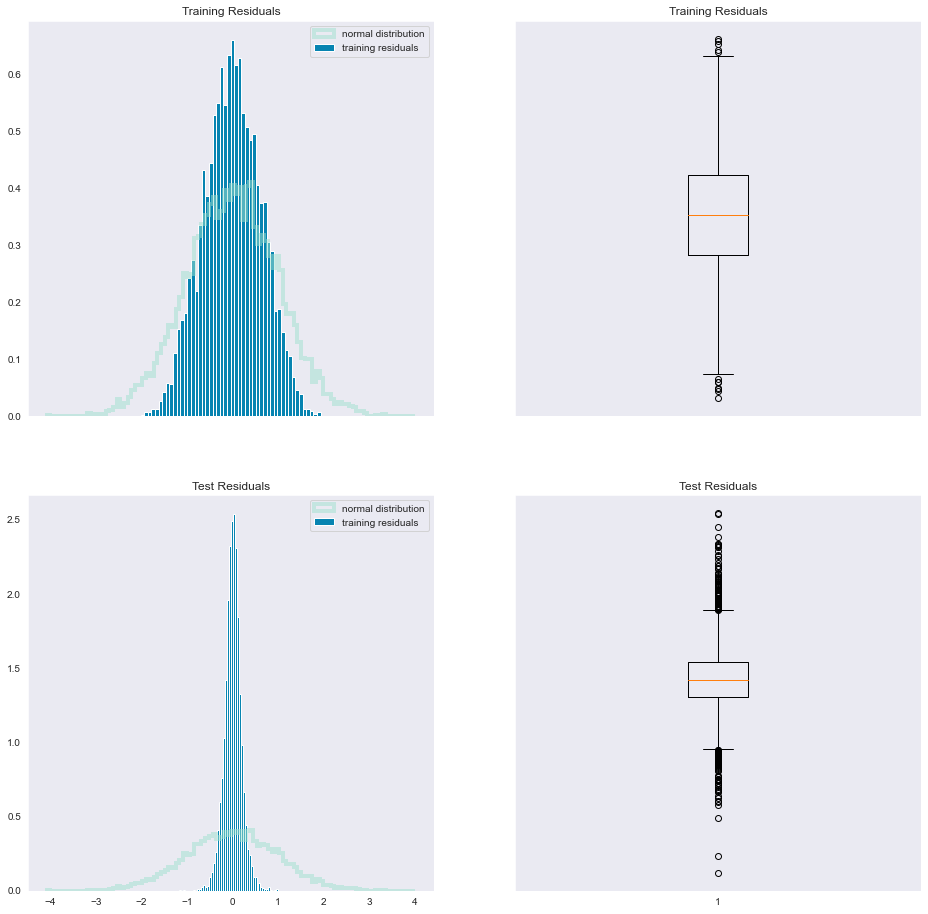

In [59]:
make_hist(residuals_no_out_train, residuals_no_out_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


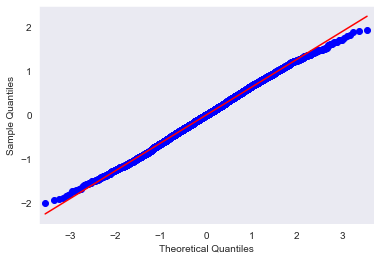

In [60]:
make_qq(pd.Series(residuals_no_out_train))

<AxesSubplot:>

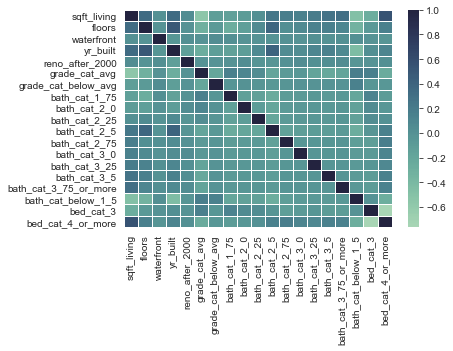

In [61]:
cols_hm_o = get_cols(X_train_no_out)

sns.heatmap(X_train_no_out[cols_hm_o].corr(), 
            center=0, 
            linewidths=0.5, 
            cmap=cmap)

### Analysis of Model With Outliers Removed

Removing the outliers dropped the R^2, but also reduced the error. The qq-plot and distributions of the residuals have improved.

## Model With Polynomial Features and Outliers Removed

In [62]:
poly_df = housing_no_outlier_processed.copy()

poly_df_price = poly_df['log_price'].reset_index(drop=True)
poly_df = poly_df.drop('log_price', axis=1)
poly_df_num = poly_df.select_dtypes('number').reset_index(drop=True)
poly_df_cat = poly_df.select_dtypes('object').reset_index(drop=True)

poly=PolynomialFeatures()

poly_features = poly.fit_transform(poly_df_num)
poly_features = pd.DataFrame(
    poly_features, columns = poly.get_feature_names(poly_df_num.columns))

poly_features = pd.concat([poly_features, poly_df_cat, poly_df_price], axis=1)
poly_features.columns = [s.replace('^','_') for s in poly_features.columns]
poly_features.columns = [s.replace(' ','_') for s in poly_features.columns]


In [63]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = split_and_process(
                                                poly_features, 'log_price')

train_df_poly = pd.concat([X_train_poly, y_train_poly], axis = 1)
X_train_poly.shape, y_train_poly.shape, train_df_poly.shape

((15366, 104), (15366,), (15366, 105))

In [64]:
formula_poly = f"{y_train_poly.name} ~ {'+'.join(X_train_poly.columns)}"
model_poly = ols(formula=formula_poly, data=train_df_poly).fit()
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     767.2
Date:                Thu, 19 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:36:52   Log-Likelihood:                 4478.2
No. Observations:               15366   AIC:                            -8752.
Df Residuals:                   15264   BIC:                            -7973.
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      12.7055      0.015    852.864      0.000      12.676      12.735
sqft_living                    -1.0104      0.153     -6.594      0.000      -1.311      -0.710
floors                          1.8239      0.164     11.134      0.000       1.503       2.145
waterfront                     -0.0479      0.070     -0.680      0.497      -0.186       0.090
yr_built                       -1.4124      0.264     -5.344      0.000      -1.930      -0.894
reno_after_2000                -0.2073      0.063     -3.290      0.001      -0.331      -0.084
sqft_living_2                  -0.1718      0.008    -21.799      0.000      -0.187      -0.156
sqft_living_floors              0.0640      0.010      6.690      0.000       0.045       0.083
sqft_living_waterfront          0.0040      0.005      0.884      0.377      -0.005       0.013
sqft_living_yr_built            1.3695      0.158      8.659      0.000       1.060       1.680
sqft_living_reno_after_2000    -0.0028      0.005     -0.576      0.564      -0.012       0.007
floors_2                        0.0185      0.011      1.672      0.095      -0.003       0.040
floors_waterfront               0.0019      0.005      0.412      0.680      -0.007       0.011
floors_yr_built                -1.9244      0.172    -11.203      0.000      -2.261      -1.588
floors_reno_after_2000         -0.0129      0.005     -2.428      0.015      -0.023      -0.002
waterfront_2                   -0.0479      0.070     -0.680      0.497      -0.186       0.090
waterfront_yr_built             0.1278      0.143      0.894      0.371      -0.152       0.408
waterfront_reno_after_2000     -0.0029      0.002     -1.873      0.061      -0.006       0.000
yr_built_2                      1.4252      0.267      5.341      0.000       0.902       1.948
yr_built_reno_after_2000        0.4368      0.126      3.463      0.001       0.190       0.684
reno_after_2000_2              -0.2073      0.063     -3.290      0.001      -0.331      -0.084
grade_cat_avg                  -0.1669      0.005    -31.714      0.000      -0.177      -0.157
grade_cat_below_avg            -0.2248      0.017    -13.227      0.000      -0.258      -0.192
zipcode_98002                  -0.0419      0.021     -2.032      0.042      -0.082      -0.001
zipcode_98003                   0.0295      0.018      1.649      0.099      -0.006       0.065
zipcode_98004                   1.1110      0.019     59.329      0.000       1.074       1.148
zipcode_98005                   0.7771      0.020     38.768      0.000       0.738       0.816
zipcode_98006                   0.6912      0.016     44.390      0.000       0.661       0.722
zipcode_98007                   0.6693      0.022     31.031      0.000       0.627       0.712
zipcode_980

In [65]:
lr_poly = LinearRegression().fit(X_train_poly, y_train_poly)
y_pred_poly = lr_poly.predict(X_test_poly)

residuals_poly_test = get_residuals(y_test_poly, y_pred_poly)
residuals_poly_train = get_residuals(y_test_poly, y_train_poly)

### Validation of Model With Polynomial Features

In [66]:
model_scores = validation('poly', 
                          lr_poly, 
                          X_train_poly, 
                          y_train_poly, 
                          residuals_poly_test)
model_scores['poly']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'train_R2': 0.82957304508005,
 'test_R2': 0.8260631846973965,
 'train_mae': -0.137651163031521,
 'test_mae': -0.13878153866004828,
 'train_mse': -0.03384865007879427,
 'test_mse': -0.03453548440314589,
 'train_rsme': 0.18398002630392862,
 'test_rsme': 0.18583725246340113,
 'JB': Jarque_beraResult(statistic=1196.7307257401008, pvalue=0.0),
 'VIF_over_10': 17,
 'Durbin-Watson': 1.9649057732403115}

In [67]:
get_high_vif(X_train_poly)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'sqft_living': 10933.328096082529,
 'floors': 12530.466184230878,
 'waterfront': inf,
 'yr_built': 32620.27275296599,
 'reno_after_2000': inf,
 'sqft_living_2': 28.771427962063957,
 'sqft_living_floors': 42.66563925410607,
 'sqft_living_yr_built': 11657.750653122834,
 'sqft_living_reno_after_2000': 10.827461424545007,
 'floors_2': 57.222149689120236,
 'floors_yr_built': 13776.143221929062,
 'floors_reno_after_2000': 13.236442937487974,
 'waterfront_2': inf,
 'waterfront_yr_built': 9530.662191760586,
 'yr_built_2': 33245.639496206284,
 'yr_built_reno_after_2000': 7429.382583619542,
 'reno_after_2000_2': inf}

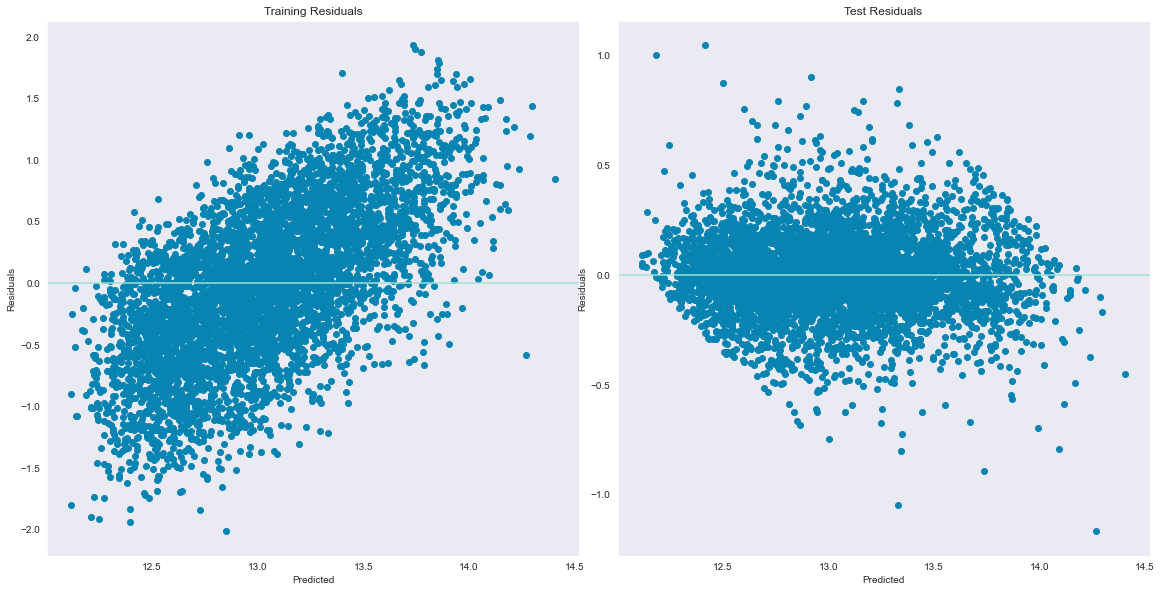

In [68]:
make_scatter(y_pred_poly, residuals_poly_train, residuals_poly_test)

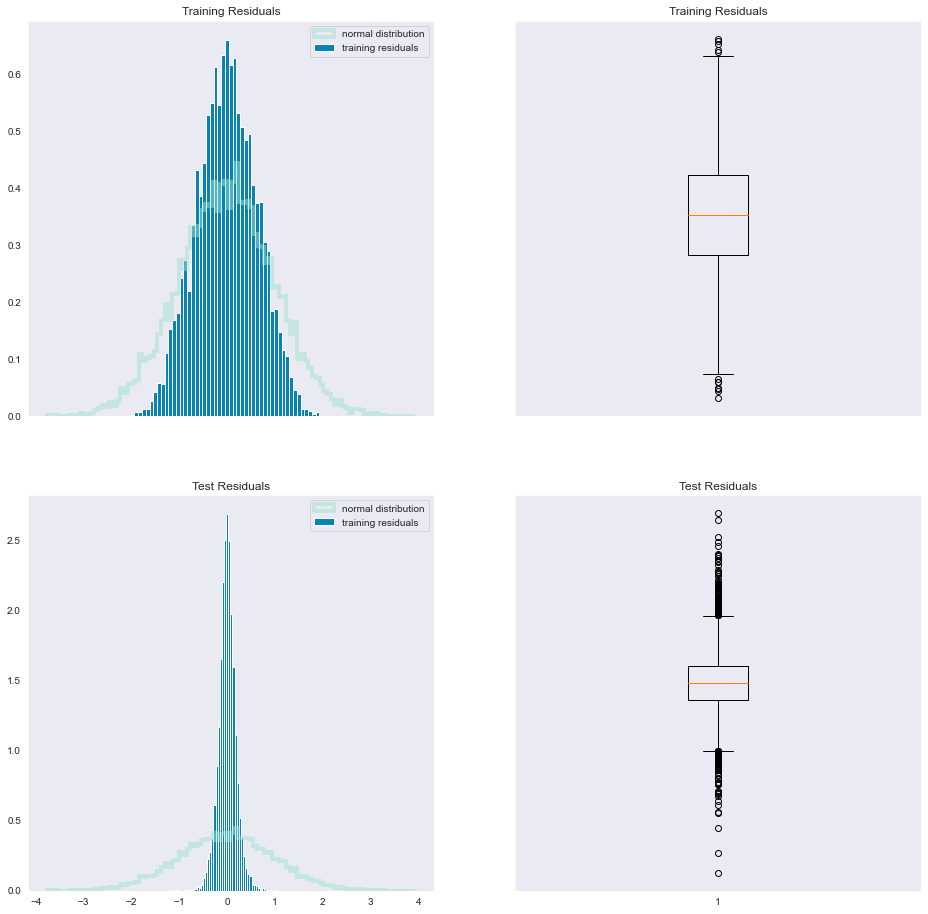

In [69]:
make_hist(residuals_poly_train, residuals_poly_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


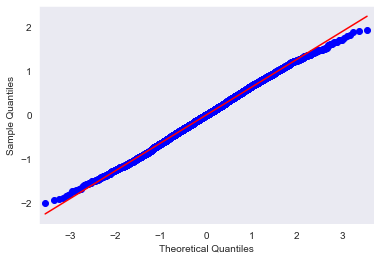

In [70]:
make_qq(pd.Series(residuals_poly_train))

<AxesSubplot:>

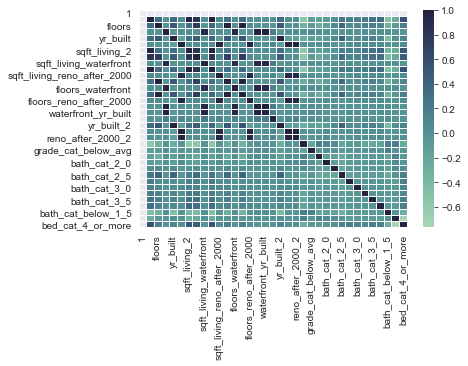

In [71]:
cols_hm_p = get_cols(X_train_poly)

sns.heatmap(X_train_poly[cols_hm_p].corr(), center=0, linewidths=0.5, cmap=cmap)

### Analysis of Model With Polynomial Features

The R^2 did not improve and there is significant multicollinearity.

## Model With Polynomial Features and Recursive Feature Elimination

In [72]:
poly_recur = poly_features.copy()
X_train_polyr, X_test_polyr, y_train_polyr, y_test_polyr = split_and_process(
                                                    poly_recur, 'log_price')

train_df_polyr = pd.concat([X_train_polyr, y_train_polyr], axis = 1)
X_train_polyr.shape, y_train_polyr.shape, train_df_polyr.shape


((15366, 104), (15366,), (15366, 105))

In [73]:
lr_polyr = LinearRegression()
selector = RFE(lr_polyr, n_features_to_select=55)
selector = selector.fit(X_train_polyr, y_train_polyr)

In [74]:
features_selected = list(zip(X_train_polyr, selector.support_))
features_selected_names = [n[0] for n in features_selected if n[1] == True]

In [75]:
feature_rankings = list(zip(X_train_polyr.columns, selector.ranking_))
feature_rankings_top = [n[0] for n in feature_rankings if n[1] < 3]

In [76]:
estimators = selector.estimator_
intercept = estimators.intercept_
feature_coef = list(zip(features_selected_names, estimators.coef_))
feature_coef

[('floors', 1.3710859968029603),
 ('waterfront', -348194767213.6522),
 ('yr_built', -3.2246481897599737),
 ('reno_after_2000', -2736699460114.7134),
 ('sqft_living_yr_built', 0.2563038137137148),
 ('floors_yr_built', -1.3972024590052694),
 ('waterfront_2', 348194767213.6898),
 ('yr_built_2', 3.271001281192815),
 ('yr_built_reno_after_2000', 0.42940315039945176),
 ('reno_after_2000_2', 2736699460114.2944),
 ('zipcode_98004', 1.002840326887931),
 ('zipcode_98005', 0.6787528066298592),
 ('zipcode_98006', 0.5931463118297144),
 ('zipcode_98007', 0.5635246690593496),
 ('zipcode_98008', 0.5499092155702316),
 ('zipcode_98011', 0.3267985153506031),
 ('zipcode_98014', 0.2502400452752519),
 ('zipcode_98024', 0.25105073623886565),
 ('zipcode_98027', 0.4029698299620442),
 ('zipcode_98028', 0.2829189633402679),
 ('zipcode_98029', 0.49141944408238836),
 ('zipcode_98033', 0.6556456548508888),
 ('zipcode_98034', 0.393223707202897),
 ('zipcode_98039', 1.1755917736017851),
 ('zipcode_98040', 0.8441356751

In [77]:
X_train_polyr = selector.transform(X_train_polyr)
X_train_polyr = pd.DataFrame(X_train_polyr)
X_train_polyr.columns = features_selected_names
X_train_polyr = X_train_polyr[features_selected_names]

X_test_polyr = selector.transform(X_test_polyr)
X_test_polyr = pd.DataFrame(X_test_polyr)
X_test_polyr.columns = features_selected_names
X_test_polyr = X_test_polyr[features_selected_names]

lr_polyr = lr_polyr.fit(X_train_polyr, y_train_polyr)
y_pred_polyr = lr_polyr.predict(X_test_polyr)

residuals_polyr_test = get_residuals(y_test_polyr, y_pred_polyr)
residuals_polyr_train = get_residuals(y_test_polyr, y_train_polyr)

X_train_polyr.shape, X_test_polyr.shape

((15366, 55), (5123, 55))

### Validation of Model With Polynomial Features and Recursive Feature Selection

In [78]:
model_scores = validation('polyr', 
                          lr_polyr, 
                          X_train_polyr, 
                          y_train_polyr, 
                          residuals_polyr_test)
model_scores['polyr']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'train_R2': 0.7930346327967674,
 'test_R2': 0.7915665508338128,
 'train_mae': -0.15326850075905699,
 'test_mae': -0.1537376779930091,
 'train_mse': -0.04110669252435775,
 'test_mse': -0.04138265626038577,
 'train_rsme': 0.20274785454933364,
 'test_rsme': 0.2034272751141935,
 'JB': Jarque_beraResult(statistic=893.1234218780065, pvalue=0.0),
 'VIF_over_10': 9,
 'Durbin-Watson': 1.9383585284742963}

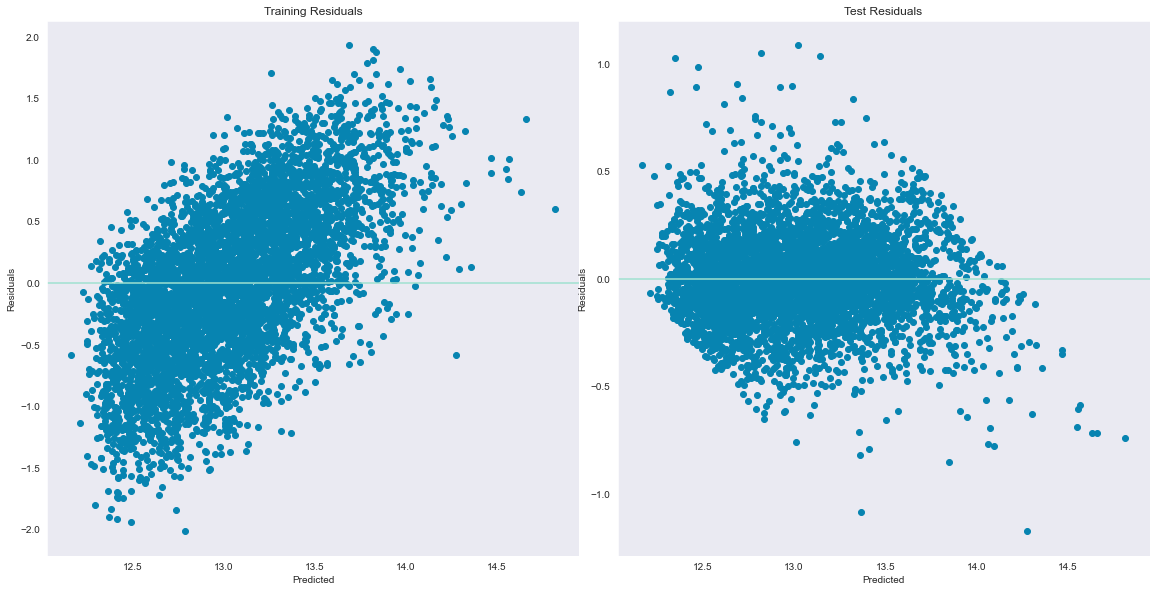

In [79]:
make_scatter(y_pred_polyr, residuals_polyr_train, residuals_polyr_test)

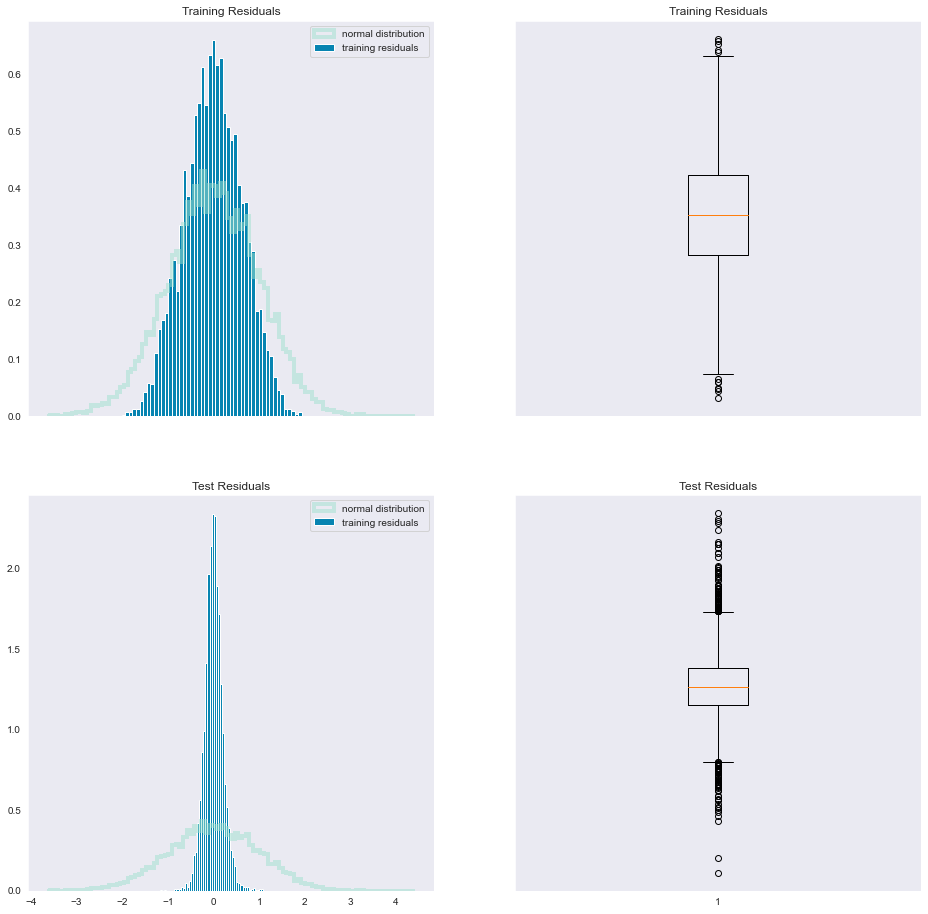

In [80]:
make_hist(residuals_polyr_train, residuals_polyr_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


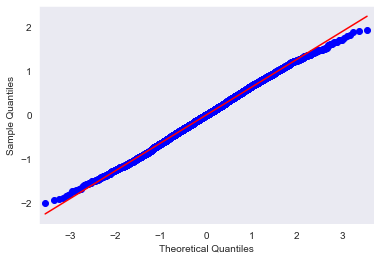

In [81]:
make_qq(pd.Series(residuals_polyr_train))

<AxesSubplot:>

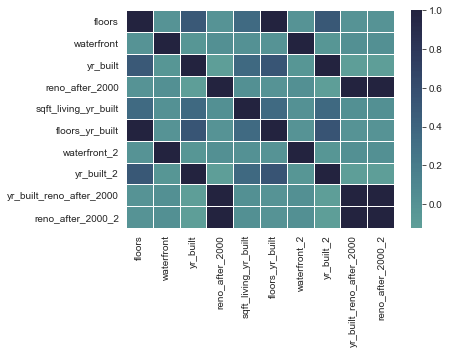

In [82]:
cols_hm_pr = get_cols(X_train_polyr)

sns.heatmap(X_train_polyr[cols_hm_pr].corr(), 
            center=0, 
            linewidths=0.5, 
            cmap=cmap)

### Analysis of Model With Polynomial Features and Recursive Feature Selection

The R^2 decreased further and there is still significant multicollinearity. Additionally, many of the coefficients do not make sense because of the interdependence of features. For example, having a renovation done after 2000 reduces the value of the home by 273,669,946,011,400%

## Revised Model

In [83]:
rev_df = housing_processed.copy()
rev_df['floors_yr_built'] = rev_df['floors'] * rev_df['yr_built']

In [84]:
#A new feature is added to capture interaction (floors_yr_built) and unneeded
#columns are removed.
cols_to_keep = ['log_price', 'bed_cat', 'sqft_living', 'waterfront', 
       'zipcode', 'reno_after_2000', 'has_basement', 'bath_cat',
       'grade_2', 'floors_yr_built']

rev_df=rev_df[cols_to_keep]

X_train_rev, X_test_rev, y_train_rev, y_test_rev = split_and_process(rev_df, 
                                                                'log_price')

train_df_rev = pd.concat([X_train_rev, y_train_rev], axis = 1)
X_train_rev.shape, y_train_rev.shape, train_df_rev.shape

((16197, 87), (16197,), (16197, 88))

In [85]:
formula = f"{y_train_rev.name} ~ {'+'.join(X_train_rev.columns)}"
model = ols(formula=formula, data=train_df_rev).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1119.
Date:                Thu, 19 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:37:53   Log-Likelihood:                 3237.2
No. Observations:               16197   AIC:                            -6298.
Df Residuals:                   16109   BIC:                            -5621.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.4956      0.015    856.832      0.000      12.467      12.524
sqft_living               0.2187      0.003     66.048      0.000       0.212       0.225
waterfront                0.0547      0.002     33.973      0.000       0.052       0.058
reno_after_2000           0.0116      0.002      7.342      0.000       0.008       0.015
has_basement             -0.0165      0.002     -8.287      0.000      -0.020      -0.013
grade_2                   0.1231      0.003     44.085      0.000       0.118       0.129
floors_yr_built          -0.0339      0.002    -14.735      0.000      -0.038      -0.029
bed_cat_3                 0.0295      0.005      5.492      0.000       0.019       0.040
bed_cat_4_or_more         0.0265      0.006      4.240      0.000       0.014       0.039
zipcode_98002            -0.0267      0.020     -1.325      0.185      -0.066       0.013
zipcode_98003             0.0227      0.019      1.208      0.227      -0.014       0.059
zipcode_98004             1.1148      0.018     62.609      0.000       1.080       1.150
zipcode_98005             0.7491      0.021     35.017      0.000       0.707       0.791
zipcode_98006             0.6558      0.016     40.637      0.000       0.624       0.687
zipcode_98007             0.6649      0.023     28.920      0.000       0.620       0.710
zipcode_98008             0.6764      0.019     36.102      0.000       0.640       0.713
zipcode_98010             0.3003      0.025     11.879      0.000       0.251       0.350
zipcode_98011             0.4508      0.021     21.435      0.000       0.410       0.492
zipcode_98014             0.3341      0.024     13.674      0.000       0.286       0.382
zipcode_98019             0.3363      0.021     16.361      0.000       0.296       0.377
zipcode_98022             0.1449      0.019      7.533      0.000       0.107       0.183
zipcode_98023            -0.0392      0.016     -2.445      0.014      -0.071      -0.008
zipcode_98024             0.4790      0.030     15.719      0.000       0.419       0.539
zipcode_98027             0.5364      0.017     32.014      0.000       0.504       0.569
zipcode_98028             0.4175      0.018     22.978      0.000       0.382       0.453
zipcode_98029             0.5926      0.018     33.197      0.000       0.558       0.628
zipcode_98030             0.0478      0.019      2.509      0.012       0.010       0.085
zipcode_98031             0.0808      0.019      4.305      0.000       0.044       0.118
zipcode_98032            -0.0221      0.024     -0.918      0.359      -0.069       0.025
zipcode_98033             0.7871      0.016     47.778      0.000       0.755       0.819
zipcode_98034             0.5423      0.016     34.392      0.000       0.511       0.573
zipcode_98038          

In [86]:
lr_rev = LinearRegression().fit(X_train_rev, y_train_rev)
y_pred_rev = lr_rev.predict(X_test_rev)

residuals_rev_test = get_residuals(y_test_rev, y_pred_rev)
residuals_rev_train = get_residuals(y_test_rev, y_train_rev)

In [87]:
coefficients = pd.DataFrame.from_dict(list(zip(X_train_rev.columns,
                                               lr_rev.coef_))).set_index(0)
coefficients.columns = ['revised_model']
coefficients[:5]

,revised_model
0,
sqft_living,0.218705
waterfront,0.054692
reno_after_2000,0.011590
has_basement,-0.016462
grade_2,0.123089


### Validation of Revised Model

In [88]:
model_scores = validation('revised', 
                          lr_rev, 
                          X_train_rev, 
                          y_train_rev, 
                          residuals_rev_test)
model_scores['revised']

{'train_R2': 0.8581669845137899,
 'test_R2': 0.8562378805520996,
 'train_mae': -0.1442985417213774,
 'test_mae': -0.1451687782633024,
 'train_mse': -0.039206388332501375,
 'test_mse': -0.039722455259439855,
 'train_rsme': 0.19800603105082779,
 'test_rsme': 0.19930493034403302,
 'JB': Jarque_beraResult(statistic=1534.6552925051087, pvalue=0.0),
 'VIF_over_10': 0,
 'Durbin-Watson': 1.9765623927364198}

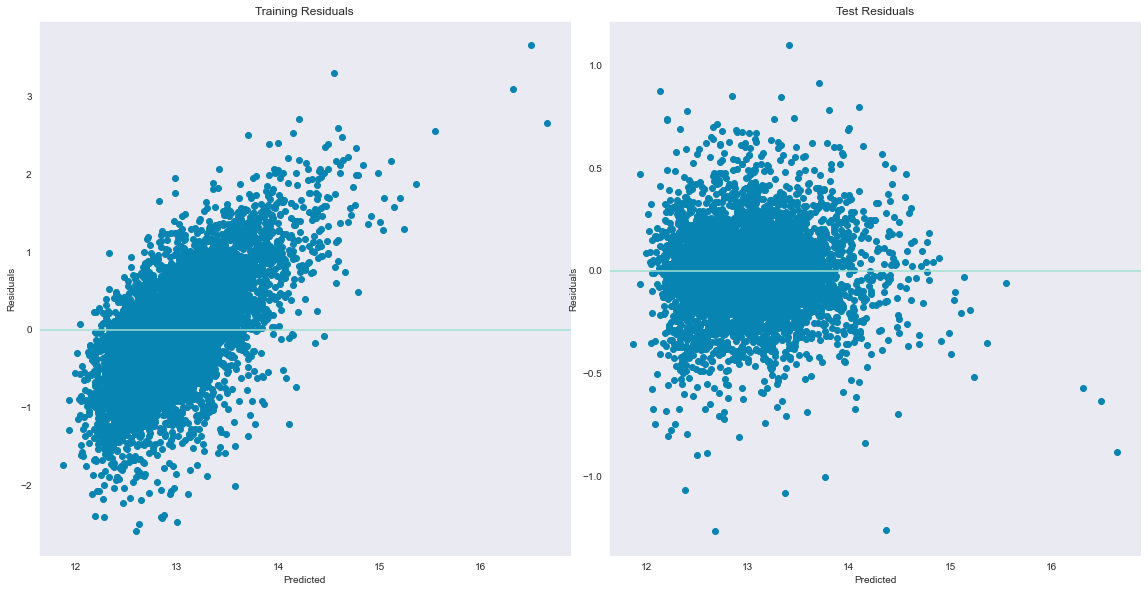

In [89]:
make_scatter(y_pred_rev, residuals_rev_train, residuals_rev_test)

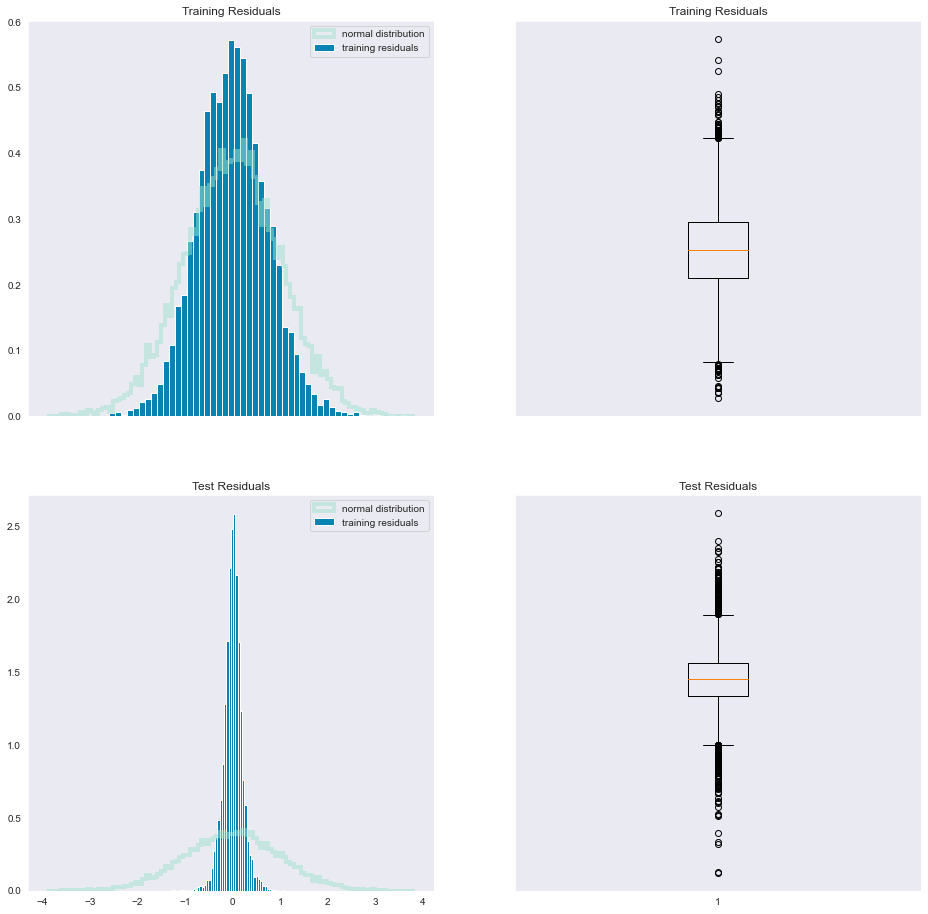

In [90]:
make_hist(residuals_rev_train, residuals_rev_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


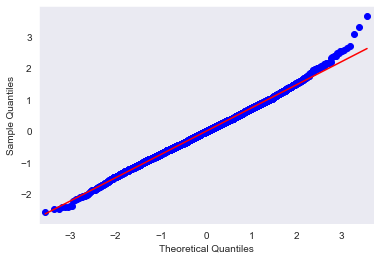

In [91]:
make_qq(pd.Series(residuals_rev_train))

<AxesSubplot:>

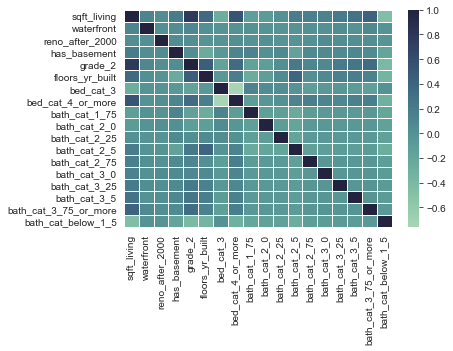

In [92]:
cols_hm_rev = get_cols(X_train_rev)

sns.heatmap(X_train_rev[cols_hm_rev].corr(), 
            center=0, 
            linewidths=0.5, 
            cmap=cmap)


### Analysis of Revised Model

The exclusion of outliers and inclusion of the feature interaction has improved the R^2 and the RMSE from the initial model. 

## Model With Regularization

In [93]:
#For the next three models I am creating a dataframe that has the outliers 
#removed but still has all of the features.
housing_reg = housing_processed.copy()
housing_reg = housing_reg.drop('price', axis=1)

upper = housing_reg['log_price'].quantile(.975)
lower = housing_reg['log_price'].quantile(.025)
housing_reg_processed = (housing_reg[(housing_reg['log_price'] < upper)
                                     &(housing_reg['log_price'] > lower)])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_and_process(
                                    housing_reg_processed, 'log_price')

train_df_reg = pd.concat([X_train_reg, y_train_reg], axis = 1)
X_train_reg.shape, y_train_reg.shape, train_df_reg.shape



((15366, 124), (15366,), (15366, 125))

### Ridge Regression With Outliers Removed

In [94]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = dict(alpha=alpha)

ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, 
                    scoring='r2', verbose=1, n_jobs=-1)
grid_result=grid.fit(X_train_reg, y_train_reg)

best_ridge_score = grid_result.best_score_
best_ridge_alpha = grid_result.best_params_['alpha']

ridge_reg = Ridge(alpha = best_ridge_alpha)
ridge_model = ridge_reg.fit(X_train_reg, y_train_reg)
y_pred_ridge = ridge_reg.predict(X_test_reg)

residuals_ridge_test = get_residuals(y_test_reg, y_pred_ridge)
residuals_ridge_train = get_residuals(y_test_reg, y_train_reg)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.3s finished


#### Validation of Ridge Model

In [95]:
model_scores = validation('ridge', 
                          ridge_reg, 
                          X_train_reg, 
                          y_train_reg, 
                          residuals_ridge_test)
model_scores['ridge']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'train_R2': 0.8520809265776436,
 'test_R2': 0.8494390479257705,
 'train_mae': -0.1282012134122615,
 'test_mae': -0.12922553750680452,
 'train_mse': -0.029379047409734266,
 'test_mse': -0.029889752089253364,
 'train_rsme': 0.17140317211106176,
 'test_rsme': 0.17288652951937397,
 'JB': Jarque_beraResult(statistic=1108.5493910183047, pvalue=0.0),
 'VIF_over_10': 109,
 'Durbin-Watson': 1.9594621798428442}

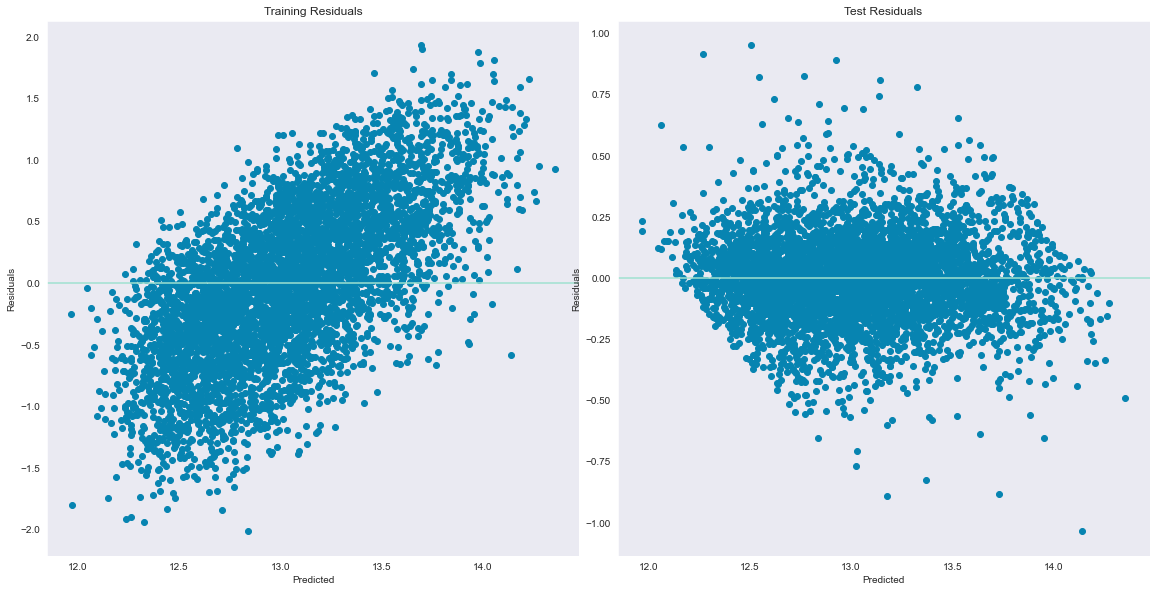

In [96]:
make_scatter(y_pred_ridge, residuals_ridge_train, residuals_ridge_test)

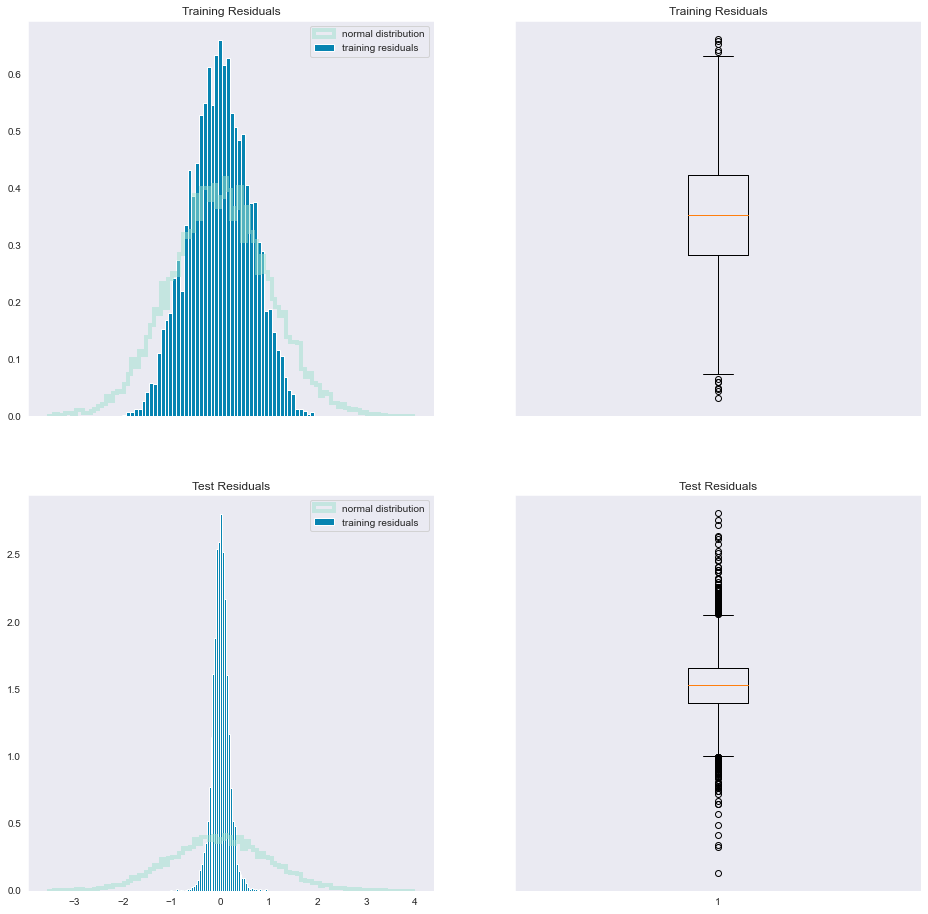

In [97]:
make_hist(residuals_ridge_train, residuals_ridge_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


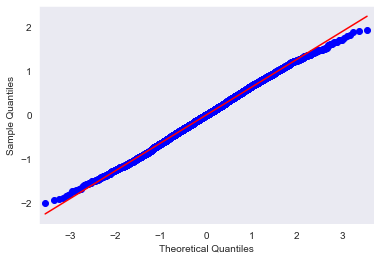

In [98]:
make_qq(pd.Series(residuals_ridge_train))

In [99]:
col_coef = list(zip(X_train_reg.columns, ridge_model.coef_))
pd.DataFrame.from_dict(col_coef).set_index(0)

,1
0,
bathrooms,-0.042211
bedrooms,-0.035781
sqft_living,0.048104
floors,-0.013621
waterfront,0.035978
...,...
bath_cat_3_5,0.281378
bath_cat_3_75_or_more,0.319521
bath_cat_below_1_5,-0.035506


<AxesSubplot:>

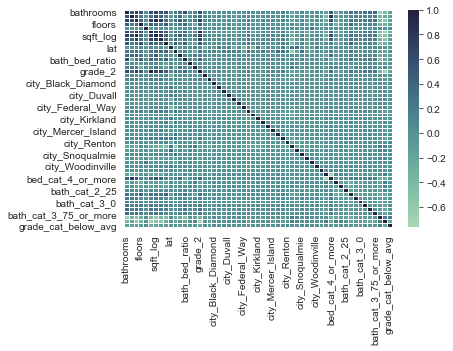

In [100]:
cols_hm_r = get_cols(X_train_reg)
sns.heatmap(X_train_reg[cols_hm_r].corr(), center=0, linewidths=0.5, cmap=cmap)

#### Analysis of Ridge Model

The ideal alpha value for the model was determined to be 0.1. Since a parameter of 0 is least squares regression, there will not be much penalty applied. In other words, the impact that a given change in x has in y will not be modified much at all. The qq-plot and error did improve.


### Lasso Regression With Outliers Removed

In [101]:
lasso = Lasso()
grid_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                    scoring='r2', verbose=1, n_jobs=-1)
grid_result_lasso=grid_lasso.fit(X_train_reg, y_train_reg)

best_score_lasso = grid_result_lasso.best_score_
best_alpha_lasso = grid_result_lasso.best_params_['alpha']

lasso_reg = Lasso(alpha = best_alpha_lasso)
lasso_model = lasso_reg.fit(X_train_reg, y_train_reg)
y_pred_lasso = lasso_reg.predict(X_test_reg)

residuals_lasso_test =  get_residuals(y_test_reg, y_pred_lasso)
residuals_lasso_train = get_residuals(y_test_reg, y_train_reg)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished


#### Validation of Lasso Model

In [102]:
model_scores = validation('lasso', 
                          lasso_reg, 
                          X_train_reg, 
                          y_train_reg, 
                          residuals_lasso_test)
model_scores['lasso']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'train_R2': 0.8290008328114509,
 'test_R2': 0.8272469390620284,
 'train_mae': -0.139065832386646,
 'test_mae': -0.13967605713867196,
 'train_mse': -0.033962920563517636,
 'test_mse': -0.03429463675667234,
 'train_rsme': 0.18429031597866893,
 'test_rsme': 0.18518811181248201,
 'JB': Jarque_beraResult(statistic=788.0436751210661, pvalue=0.0),
 'VIF_over_10': 109,
 'Durbin-Watson': 1.9967378711281745}

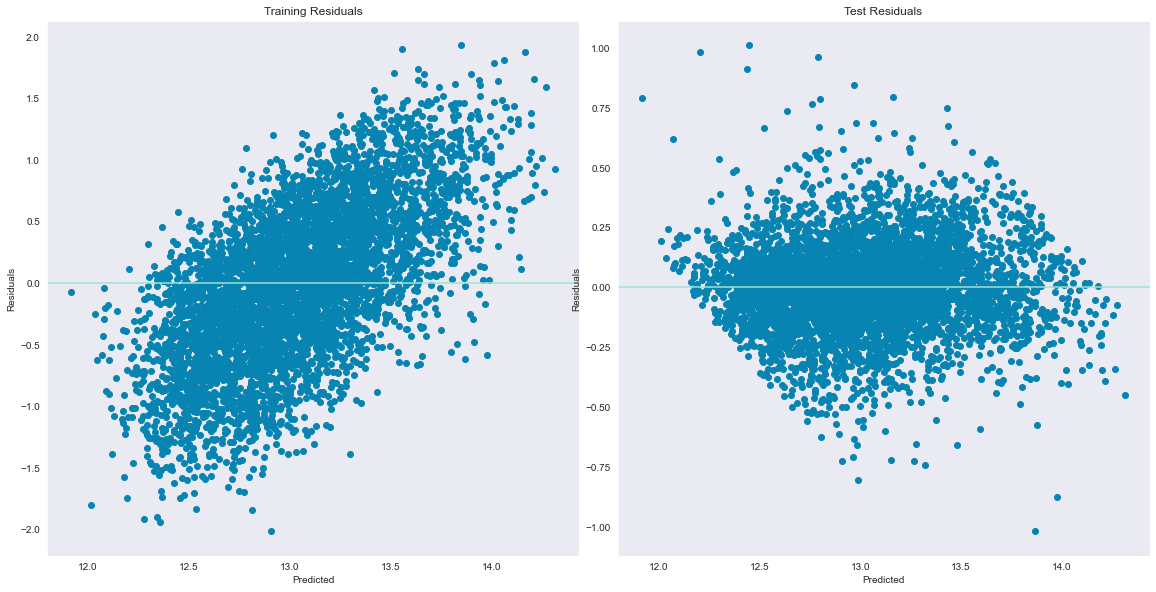

In [103]:
make_scatter(y_pred_lasso, residuals_lasso_train, residuals_lasso_test)

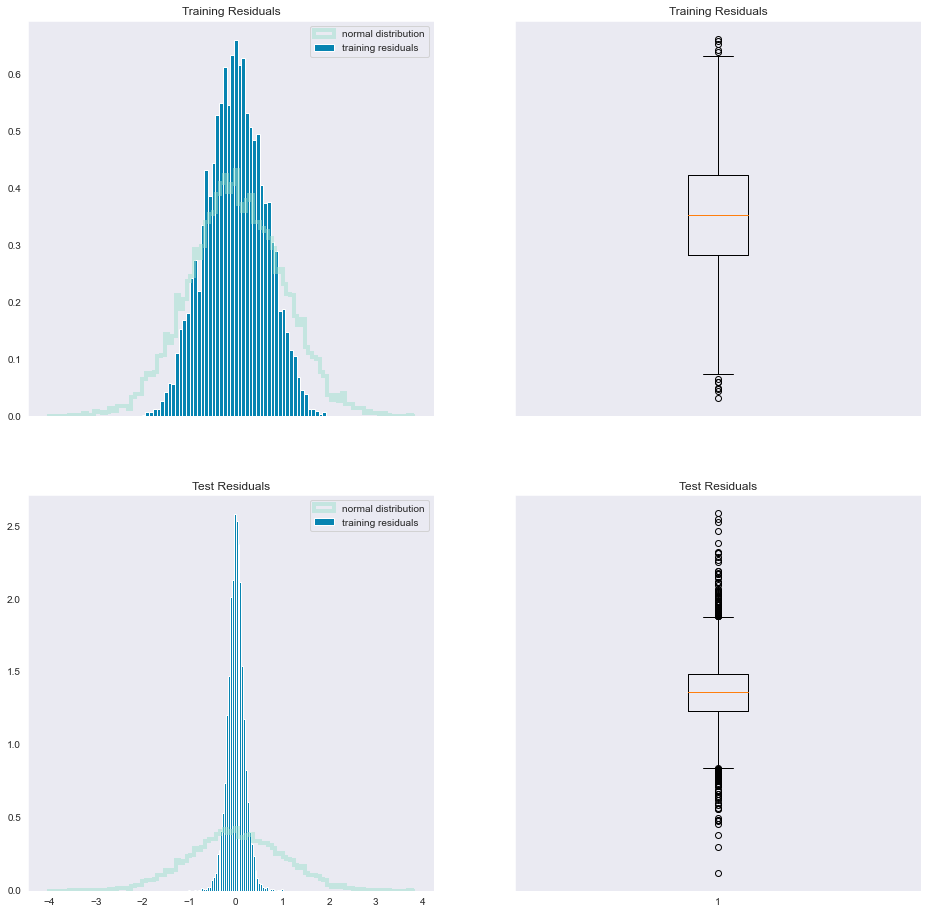

In [104]:
make_hist(residuals_lasso_train, residuals_lasso_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


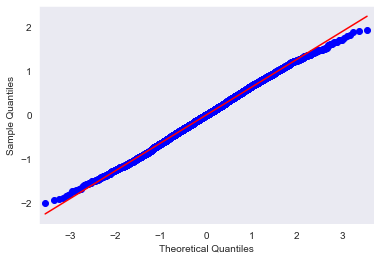

In [105]:
make_qq(pd.Series(residuals_lasso_train))

In [106]:
col_coef = list(zip(X_train_reg.columns, lasso_model.coef_))
zero_count = 0
for i in range(len(col_coef)):
    if col_coef[i][1] == 0:
        zero_count+=1
zero_count

65

<AxesSubplot:>

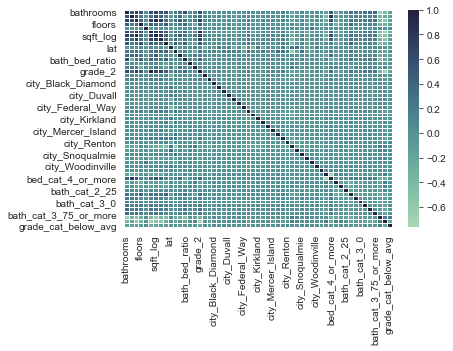

In [107]:
cols_hm_l = get_cols(X_train_reg)

sns.heatmap(X_train_reg[cols_hm_l].corr(), 
            center=0, 
            linewidths=0.5, 
            cmap=cmap)

#### Analysis of Lasso Model

The best hyperparameter is 0.001, very close to 0, which suggests that this is not a good model. 65 of the feature coefficients were reduced to 0, but there is still significant multicollinearity. 

### Elastic Net Regression With Outliers Removed

In [108]:
#0 and 1 are not in the L1 ratio list because ridge and lasso regressions 
#have alredy been performed
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid_en = dict(alpha=alpha, l1_ratio=l1_ratio)

elastic_net = ElasticNet()

grid_en = GridSearchCV(estimator=elastic_net, param_grid=param_grid_en,
                    scoring='r2', verbose=1, n_jobs=-1)
grid_result_en = grid_en.fit(X_train_reg, y_train_reg)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:   12.8s finished


In [109]:
best_score_en = grid_result_en.best_score_
best_alpha_en = grid_result_en.best_params_['alpha']
best_l1_en = grid_result_en.best_params_['l1_ratio']
best_l1_en

0.1

In [110]:
en_reg = ElasticNet(alpha = best_alpha_en, l1_ratio=best_l1_en)
en_model = en_reg.fit(X_train_reg, y_train_reg)
y_pred_en = en_reg.predict(X_test_reg)

residuals_en_test = get_residuals(y_test_reg, y_pred_en)
residuals_en_train = get_residuals(y_test_reg, y_train_reg)

#### Validation of Elastic Net Model

In [111]:
model_scores = validation('elastic_net', 
                          en_reg, 
                          X_train_reg, 
                          y_train_reg, 
                          residuals_en_test)
model_scores['elastic_net']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'train_R2': 0.8493032280734386,
 'test_R2': 0.846939511219659,
 'train_mae': -0.12969025353172112,
 'test_mae': -0.13058947020350622,
 'train_mse': -0.02993073557707976,
 'test_mse': -0.03038530061703524,
 'train_rsme': 0.1730050160460088,
 'test_rsme': 0.17431379927313626,
 'JB': Jarque_beraResult(statistic=942.1327960418951, pvalue=0.0),
 'VIF_over_10': 109,
 'Durbin-Watson': 1.9687717380915148}

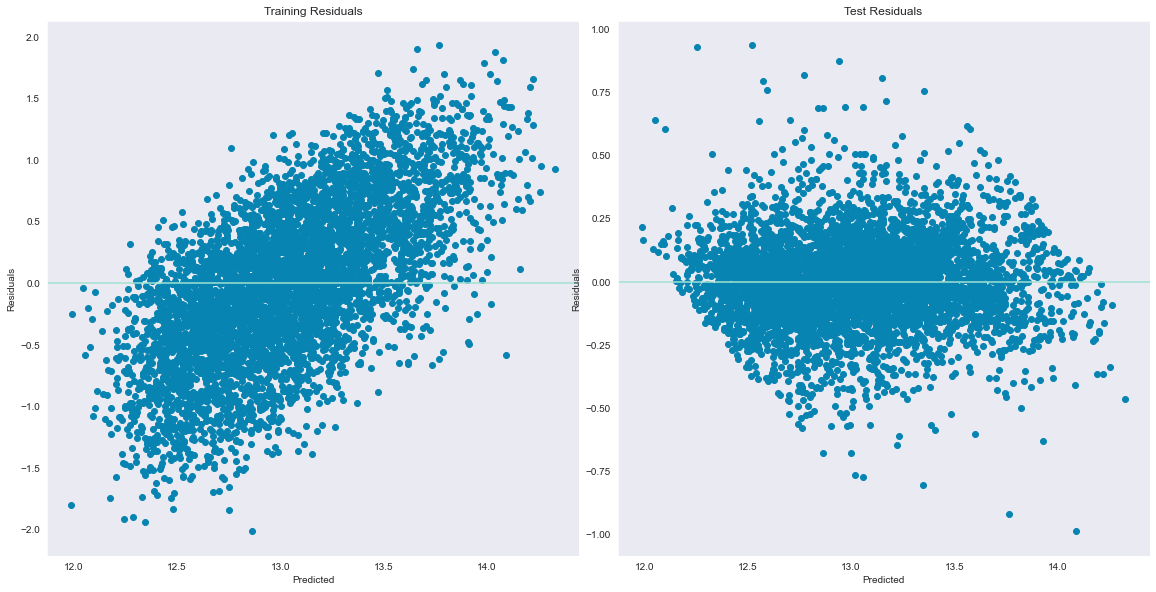

In [112]:
make_scatter(y_pred_en, residuals_en_train, residuals_en_test)

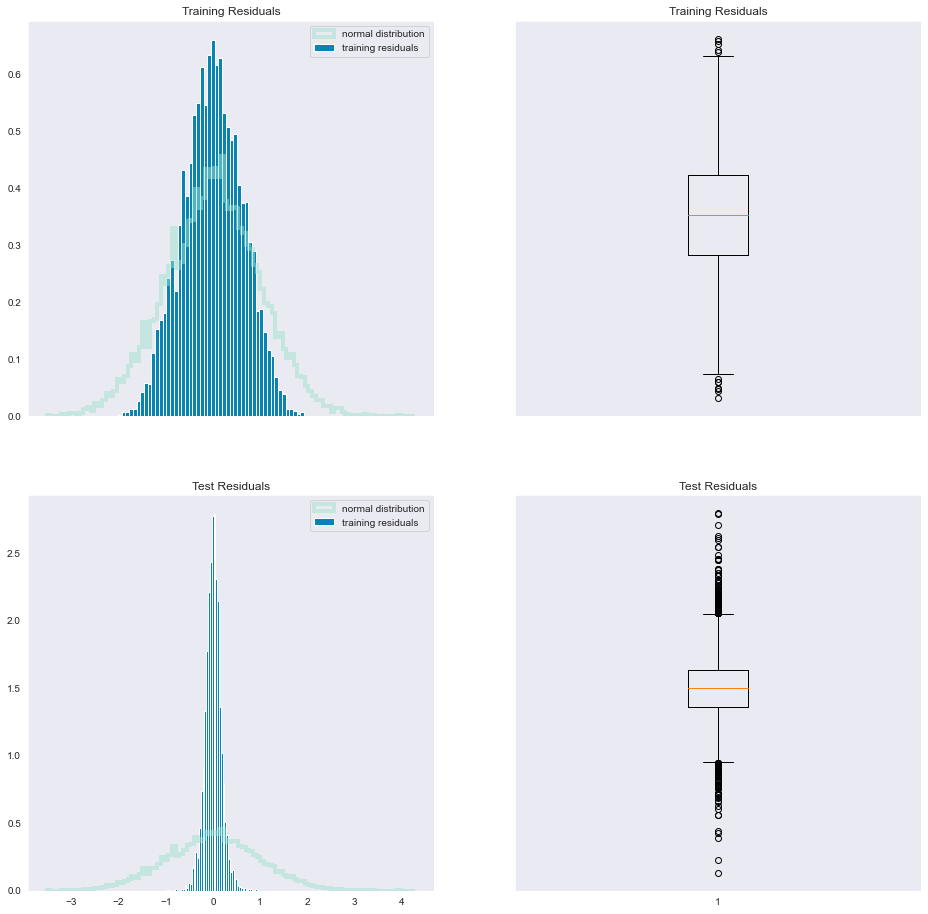

In [113]:
make_hist(residuals_en_train, residuals_en_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


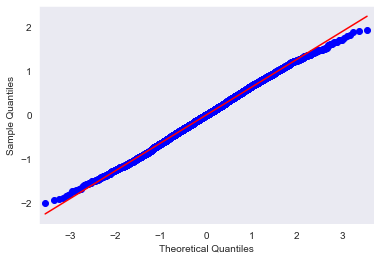

In [114]:
make_qq(pd.Series(residuals_en_train))

In [115]:
col_coef = list(zip(X_train_reg.columns, en_model.coef_))

<AxesSubplot:>

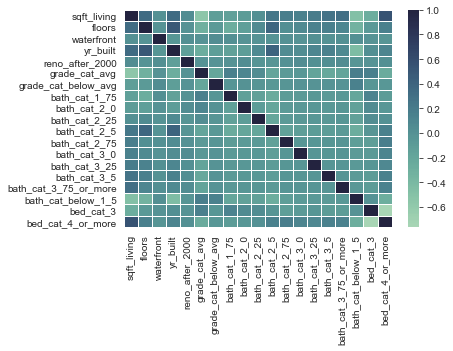

In [116]:
cols_hm_en = get_cols(X_train_reg)

sns.heatmap(X_train_reg[cols_hm].corr(), 
            center=0, 
            linewidths=0.5,  
            cmap=cmap)

#### Analysis of Elastic Net Model

The L1 hyperparameter of 0.1 indicates that this is leaning towards a ridge model, which supports the conclusion that lasso was not a good fit. The performance is not improved. 

### Ridge Regression Revised

In [117]:
ridge_rev = Ridge()
grid = GridSearchCV(estimator=ridge_rev, param_grid=param_grid, 
                    scoring='r2', verbose=1, n_jobs=-1)
grid_result=grid.fit(X_train_rev, y_train_rev)

best_ridge_score = grid_result.best_score_
best_ridge_alpha = grid_result.best_params_['alpha']

ridge_rev = Ridge(alpha = best_ridge_alpha)
ridge_model_rev = ridge_rev.fit(X_train_rev, y_train_rev)
y_pred_ridge_rev = ridge_rev.predict(X_test_rev)

residuals_ridge_rev_test = get_residuals(y_test_rev, y_pred_rev)
residuals_ridge_rev_train = get_residuals(y_test_rev, y_train_rev)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished


In [118]:
ridge_coefficients = pd.DataFrame.from_dict(
    list(zip(X_train_rev.columns,ridge_model_rev.coef_))).set_index(0)
ridge_coefficients.columns = ['ridge_revised']

coefficients_compare = pd.concat([coefficients, ridge_coefficients], axis=1)
coefficients_compare = coefficients_compare.loc[:, 
                                ~coefficients_compare.columns.duplicated()]
coefficients_compare['difference'] = (np.abs(
    coefficients_compare['revised_model'] 
    - coefficients_compare['ridge_revised']))
coefficients_compare

,revised_model,ridge_revised,difference
0,,,
sqft_living,0.218705,0.218703,2.798915e-06
waterfront,0.054692,0.054692,1.071536e-08
reno_after_2000,0.011590,0.011593,2.637983e-06
has_basement,-0.016462,-0.016449,1.387045e-05
grade_2,0.123089,0.123107,1.793552e-05
...,...,...,...
bath_cat_3_0,0.077025,0.077013,1.179392e-05
bath_cat_3_25,0.084714,0.084712,1.863125e-06
bath_cat_3_5,0.071743,0.071728,1.532773e-05


#### Validation of Ridge Regression Revised

In [119]:
model_scores = validation('ridge_revised', ridge_rev, X_train_rev, y_train_rev, residuals_ridge_rev_test)
model_scores['ridge_revised']

{'train_R2': 0.8581668236071103,
 'test_R2': 0.8562382373011985,
 'train_mae': -0.14429923751079515,
 'test_mae': -0.1451694105091855,
 'train_mse': -0.03920643281804802,
 'test_mse': -0.03972238001705417,
 'train_rsme': 0.19800614338461325,
 'test_rsme': 0.19930474158196582,
 'JB': Jarque_beraResult(statistic=1534.6552925051087, pvalue=0.0),
 'VIF_over_10': 0,
 'Durbin-Watson': 1.9765623927364198}

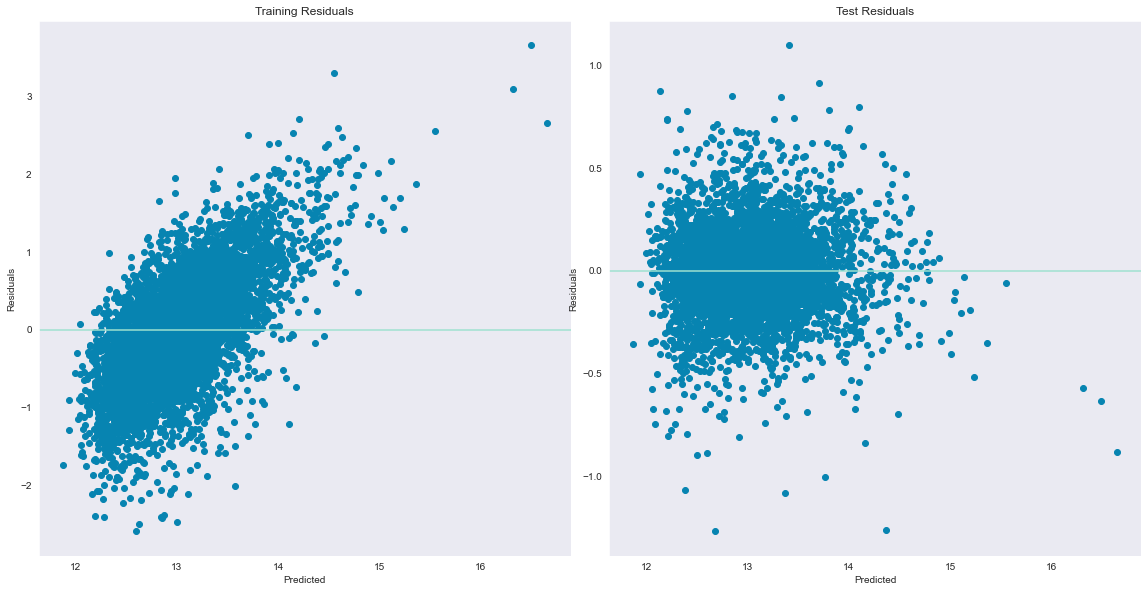

In [120]:
make_scatter(y_pred_ridge_rev, residuals_ridge_rev_train, residuals_ridge_rev_test)

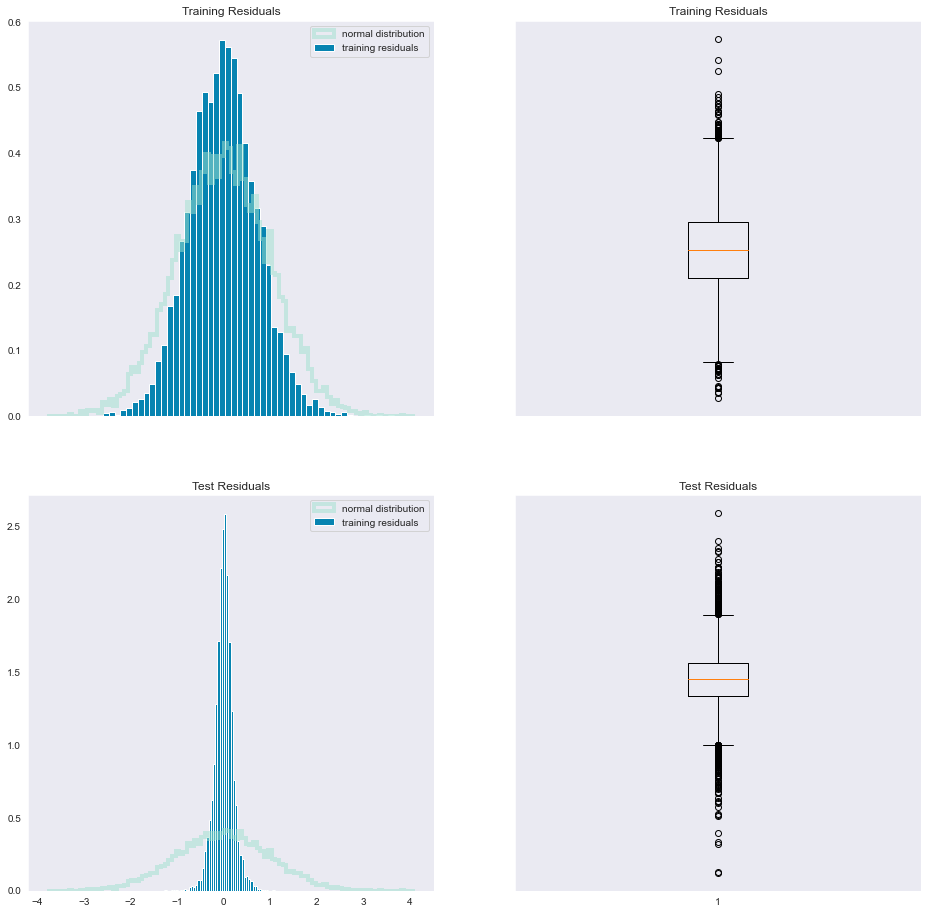

In [121]:
make_hist(residuals_ridge_rev_train, residuals_ridge_rev_test)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


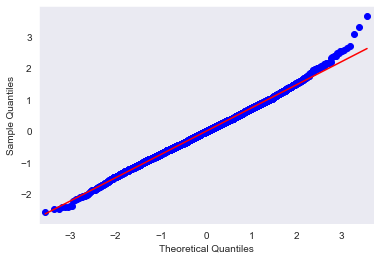

In [122]:
make_qq(pd.Series(residuals_ridge_rev_train))

<AxesSubplot:>

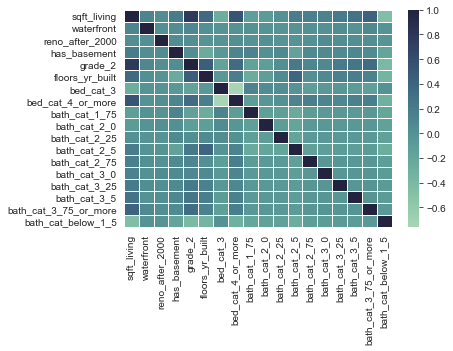

In [123]:
cols_hm_red_rev = get_cols(X_train_rev)

sns.heatmap(X_train_rev[cols_hm_red_rev].corr(), center=0, linewidths=0.5, cmap=cmap)

#### Analysis of Ridge Regression Revised

The coefficients and metrics are very similar to the revised model that used least square regression. This suggests that this data is not prone to an issue with overfitting. 

# Model Selection

In [124]:
model_scores_df = pd.DataFrame(model_scores).T
model_scores_df

,train_R2,test_R2,train_mae,test_mae,train_mse,test_mse,train_rsme,test_rsme,JB,VIF_over_10,Durbin-Watson
initial,0.851448,0.849536,-0.14832,-0.149218,-0.0410638,-0.0415749,0.202642,0.203899,"(1304.183728714113, 0.0)",0,1.97648
no_outliers,0.82791,0.825304,-0.13807,-0.138993,-0.0341797,-0.0346818,0.184878,0.18623,"(1060.1194380265356, 0.0)",0,1.96312
poly,0.829573,0.826063,-0.137651,-0.138782,-0.0338487,-0.0345355,0.18398,0.185837,"(1196.7307257401008, 0.0)",17,1.96491
polyr,0.793035,0.791567,-0.153269,-0.153738,-0.0411067,-0.0413827,0.202748,0.203427,"(893.1234218780065, 0.0)",9,1.93836
revised,0.858167,0.856238,-0.144299,-0.145169,-0.0392064,-0.0397225,0.198006,0.199305,"(1534.6552925051087, 0.0)",0,1.97656
ridge,0.852081,0.849439,-0.128201,-0.129226,-0.029379,-0.0298898,0.171403,0.172887,"(1108.5493910183047, 0.0)",109,1.95946
lasso,0.829001,0.827247,-0.139066,-0.139676,-0.0339629,-0.0342946,0.18429,0.185188,"(788.0436751210661, 0.0)",109,1.99674
elastic_net,0.849303,0.84694,-0.12969,-0.130589,-0.0299307,-0.0303853,0.173005,0.174314,"(942.1327960418951, 0.0)",109,1.96877
ridge_revised,0.858167,0.856238,-0.144299,-0.145169,-0.0392064,-0.0397224,0.198006,0.199305,"(1534.6552925051087, 0.0)",0,1.97656


The revised model using ordinary least squares is selected because it has a high R^2 value, no problems with multicollinearity and a reasonable error rate. According to the coefficients in this model, 
- Adding approximately 900 square feet (1 standard deviation) is expected to increase the sale price of the house by 21-23%, all other features held constant.
- Adding a 2nd bathroom is expected to increase the sale price by 2-5%.
- Adding a 3rd bedroom is expected to increase the sale price by 2-4%.
- Doing a remodel (assuming one has not been done since 2000) is expected to increase the sale price by 0.8 and 1.5%

## Linear Assumptions

### Linearity

The selected features have a linear relationship with the target.

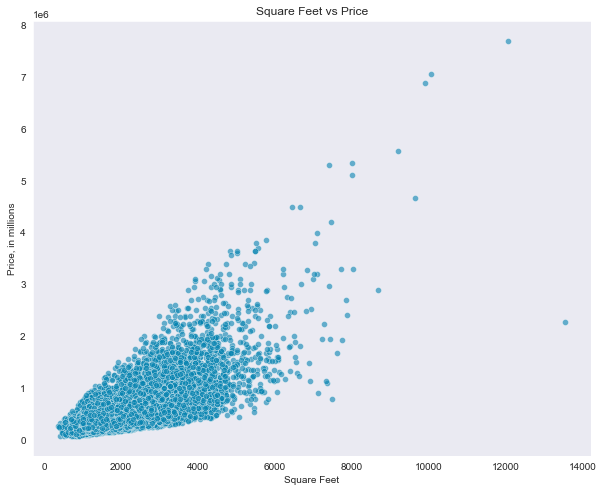

In [125]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=housing, 
    x='sqft_living', 
    y='price', 
    alpha=0.6, 
    color=NEUTRAL)
plt.title('Square Feet vs Price')
plt.ylabel('Price, in millions')
plt.xlabel('Square Feet');


### Normal Distribution of Residuals

While not perfectly normal due to leptokurtosis (the residuals are clustered around 0), the residuals are not skewed and the qq-plots look quite good for the majority of the data.

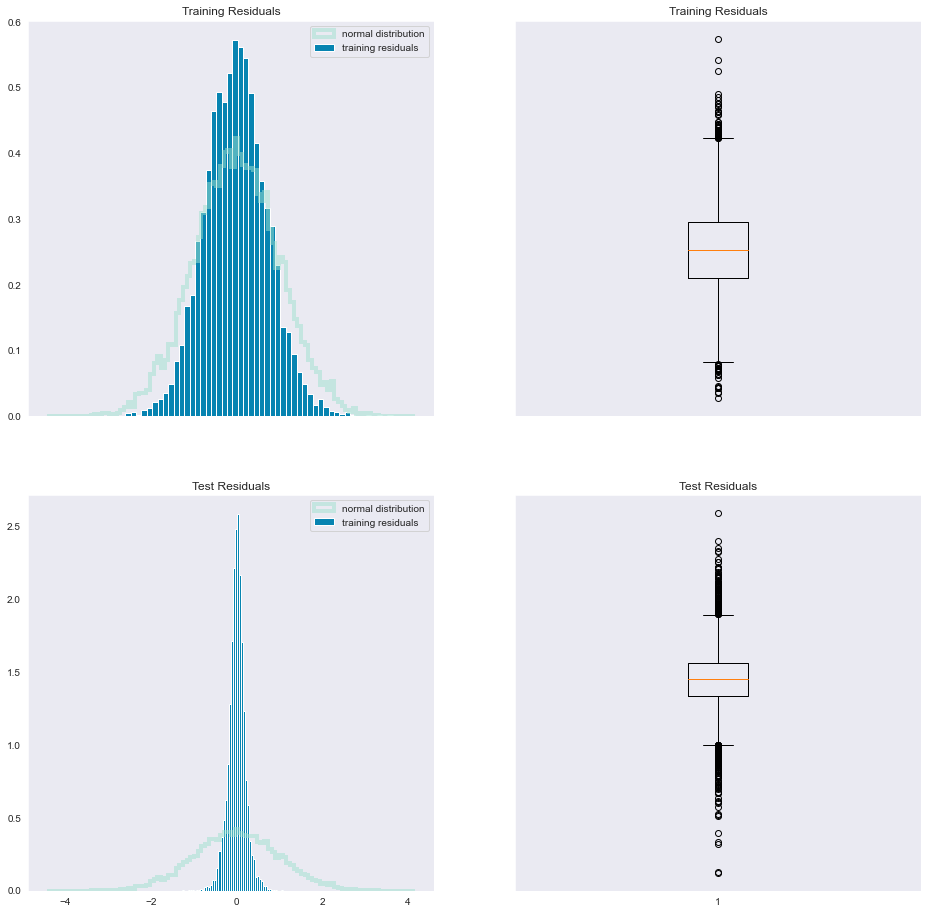

In [126]:
make_hist(residuals_rev_train, residuals_rev_test)

### Homoscedasticity

The Durbin-Watson score of 1.98 is between 1.5 and 2.5, which indicates that the residuals are homoscedastic. This can also be seen on the scatter plots, where there is no fanning or pattern. 

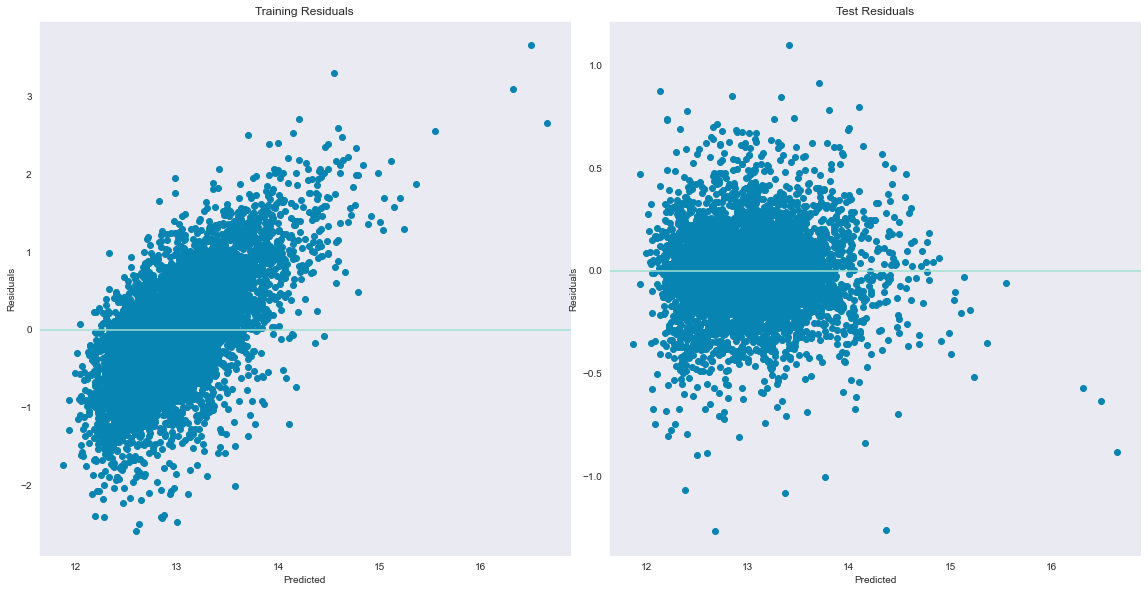

In [127]:
make_scatter(y_pred_rev, residuals_rev_train, residuals_rev_test)

### Independence of Independent Variables

No VIF scores are above 10, which shows reasonable independence between variables. This is also confirmed with the correlations shown in the heatmap. 

<AxesSubplot:>

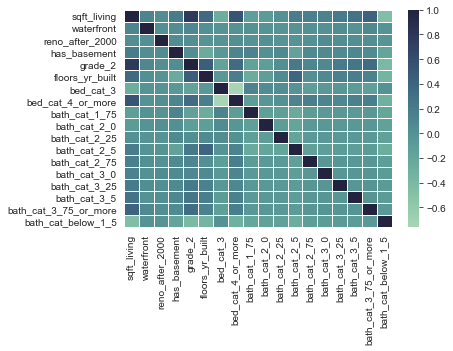

In [128]:
sns.heatmap(X_train_rev[cols_hm_rev].corr(), 
            center=0, 
            linewidths=0.5, 
            cmap=cmap)

# Pipeline Creation

In [129]:
#Create a partial pipeline in order to make predictions on new data.
X = rev_df.drop('log_price', axis=1)
y = rev_df['log_price']

In [131]:
num_bath = sorted(rev_df['bath_cat'].unique())
num_bath[0] = 'below_1_5'
num_bath.pop()

def add_bath(bathrooms, size):
    
    """Takes in a current number of bathrooms and the size of the addition (0.25,
    0.5, 0.75, 1) and returns the new number of bathrooms."""

    i = num_bath.index(bathrooms)
    if bathrooms == 'below_1_5' and size < 1:
        return '1_75'
    elif bathrooms == 'below_1_5' and size == 1:
        return '2_0'
    else:
        if size == 0.25:
            add = 1
        elif size == 0.5:
            add = 2
        elif size == 0.75:
            add = 3
        else:
            add = 4
        try:
            return num_bath[i+add]
        except:
            return num_bath[-1]


In [134]:
num_bed = sorted(rev_df['bed_cat'].unique())

def add_bed(bedrooms):
    
    """ Takes in the current number of bedrooms and returns the number of
    bedrooms after an addition."""

    
    i = num_bed.index(bedrooms)
    try:
        return num_bed[i+1]
    except:
        return num_bed[-1]
    

In [136]:
(BEDROOMS, SQFT, WATERFRONT, ZIPCODE, RENO_AFTER_2000, HAS_BASEMENT, 
 BATHROOMS,GRADE_2, FLOORS_YR_BUILT) = ('3', 1410, 0, 98133, 0, 1, 
                                        'below_1_5', 49, 1970)
houses_predict = pd.DataFrame()
houses_predict['original'] = ([BEDROOMS,SQFT, WATERFRONT, ZIPCODE, 
                               RENO_AFTER_2000, HAS_BASEMENT, BATHROOMS,
                               GRADE_2, FLOORS_YR_BUILT ])
houses_predict.index = list(X.columns)
houses_predict['add_400_sqft'] = houses_predict['original']
houses_predict['add_400_sqft'].loc['sqft_living'] = SQFT + 400
houses_predict['add_400_sqft'].loc['reno_after_2000'] = 1
houses_predict['add_bath'] = houses_predict['original']
houses_predict['add_bath'].loc['bath_cat'] = add_bath(BATHROOMS, 1)
houses_predict['add_bath'].loc['reno_after_2000'] = 1
houses_predict['add_bed'] = houses_predict['original']
houses_predict['add_bed'].loc['bed_cat'] = add_bed(BEDROOMS)
houses_predict['add_bed'].loc['reno_after_2000'] = 1
houses_predict['add_bath_bed_sqft'] = houses_predict['original']
houses_predict['add_bath_bed_sqft'].loc['sqft_living'] = SQFT + 400
houses_predict['add_bath_bed_sqft'].loc['bath_cat'] = add_bath(BATHROOMS, 1)
houses_predict['add_bath_bed_sqft'].loc['bed_cat'] = add_bed(BEDROOMS)
houses_predict['add_bath_bed_sqft'].loc['reno_after_2000'] = 1

houses_predict = houses_predict.T

In [137]:
num_attribs = X.select_dtypes('number').columns
cat_attribs = X.select_dtypes('object').columns

transform = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(drop='first'), cat_attribs)
])

pipeline = Pipeline(steps = [('transform', transform),
                              ('model',LinearRegression() )
                              ])

pipeline.fit(X,y)
predictions = pipeline.predict(houses_predict)

renovations = (['original','add_400_sqft', 'add_bath', 'add_bed', 
                'add_bath_bed_sqft'])
predictions_transformed = [np.e**x for x in predictions]
predictions_transformed = list(zip(renovations, predictions_transformed))
prediction_df = pd.DataFrame.from_dict(predictions_transformed)
prediction_df.columns = ['Addition','Predicted Sale Price']
prediction_df

,Addition,Predicted Sale Price
0,original,340189.289768
1,add_400_sqft,410544.524826
2,add_bath,394012.775872
3,add_bed,373902.880054
4,add_bath_bed_sqft,433515.779538


# Conclusions and Recommendations

The current website design should be updated to request current house information from users and include the price predictions from the linear regression model to show homeowners the personalized return on investment they can expect to gain if they move forward with the renovation. If homeowners are able to see how increasing their square footage or rooms can increase the value of their home, they are more likely to be willing to spend the money on the renovation.

There 16,491 homes that are over 20 years old and have not been updated and may benefit from renovation. They have an average of 2 bathrooms, 3 bedrooms and 1,820 square feet, which is below the average size home for the area. Future advertising should be directed towards these homeowners.

In order to maximize sales:

- First implement the price prediction tool on the website. 
- Then, use targeted advertising to reach the areas in the county that have the most homes that are more than 20 years old and not updated. 

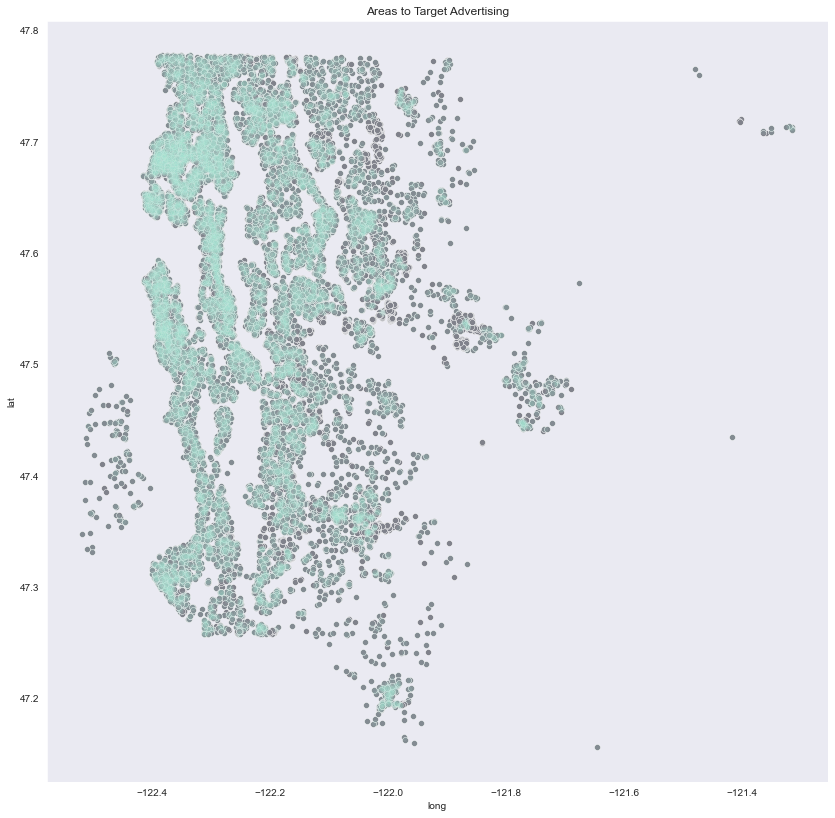

In [138]:
fig, ax = plt.subplots(figsize=(14,14))
sns.scatterplot(data=housing_processed, 
                x='long', 
                y='lat', 
                color=DULL)
sns.scatterplot(data=older_no_reno, 
                x='long', 
                y='lat', 
                color=HIGHLIGHT, 
                alpha=0.1)
plt.title('Areas to Target Advertising');


# Future Work

- This model was built using data from 2014 and 2015, which is obviously outdated. Newer data needs to be obtained, which may require updating the model. Ideally, new data would be batch processed every month or so in order to be able to capture trends in the industry. 

- In this project, zip code was used as a proxy for location. Ideally, this would be replaced with metrics about distance to schools, parks, highways, major employers, etc.

- Once the model is updated, it will need to be deployed on the website. This will require the assistance of a website designer. 


